<a href="https://colab.research.google.com/github/harrybirdnz/ZZSC9020-Group_F/blob/main/individual/cameron/LSTM-sum_demand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
from pathlib import Path
from dotenv import load_dotenv
from google.colab import drive

drive.mount('/content/drive')
env_path = '/content/drive/MyDrive/secrets/.env'
if os.path.exists(env_path):
    token = os.getenv('GITHUB_TOKEN')
    load_dotenv(env_path)
    print("Secrets loaded from .env")
else:
    print(".env file not found at:", env_path)

REPO_NAME = 'ZZSC9020-Group_F'
repo_url_mid = 'https://github.com/harrybirdnz/ZZSC9020-Group_F'
REPO_URL = repo_url_mid.replace('https://', f'https://{token}@')
REPO_PATH = f"/content/{REPO_NAME}"
NOTEBOOK_SUBDIR = 'individual/cameron'

if not os.path.exists(REPO_PATH):
    print(f"Cloning repo: {REPO_NAME}")
    !git clone {REPO_URL}
else:
    print(f"Repo already exists at: {REPO_PATH}")
    os.chdir(REPO_PATH)
    print("Pulling changes from repo...")
    !git pull


target_path = os.path.join(REPO_PATH, NOTEBOOK_SUBDIR)
if os.path.exists(target_path):
    os.chdir(target_path)
    print(f"Working directory set to: {os.getcwd()}")
else:
    print(f"Target notebook path not found: {target_path}")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Secrets loaded from .env
Cloning repo: ZZSC9020-Group_F
Cloning into 'ZZSC9020-Group_F'...
remote: Enumerating objects: 562, done.
remote: Counting objects: 100% (164/164), done.
remote: Compressing objects: 100% (143/143), done.
remote: Total 562 (delta 38), reused 129 (delta 16), pack-reused 398 (from 1)
Receiving objects: 100% (562/562), 304.86 MiB | 26.91 MiB/s, done.
Resolving deltas: 100% (163/163), done.
Updating files: 100% (77/77), done.
Working directory set to: /content/ZZSC9020-Group_F/individual/cameron


### Imports ###

In [3]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 7.6 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import random
import optuna

from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsolutePercentageError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.saving import register_keras_serializable
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

SEED = 42

random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

es1 = EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True,
    verbose=1
)

es2 = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

es3 = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)


In [5]:
test_df = pd.read_csv('../../data/processed/processed2.csv')
test_df.head()

datetime_au  is_summer  is_autumn  is_winter  is_spring  is_sunday  \
0  2016-01-01          1          0          0          0          0   
1  2016-01-02          1          0          0          0          0   
2  2016-01-03          1          0          0          0          1   
3  2016-01-04          1          0          0          0          0   
4  2016-01-05          1          0          0          0          0   

   is_monday  is_tuesday  is_wednesday  is_thursday  ...  max_30_min_demand  \
0          0           0             0            0  ...            7913.75   
1          0           0             0            0  ...            7390.04   
2          0           0             0            0  ...            7328.39   
3          1           0             0            0  ...            8313.11   
4          0           1             0            0  ...            8338.82   

   sum_30_min_demand  count_30_min_points   avg_temp  min_temp  max_temp  \
0          329352.88                   48  20.704082      15.2      26.0   
1          323133.95                   48  20.572917      14.9      24.2   
2          317665.92                   48  21.130769      19.0      22.9   
3          353210.40                   48  20.144444      18.4      23.1   
4          358082.97                   48  18.904808      17.4      20.3   

   hd_next_24h  cd_next_24h  precipitation  sunlight  
0          0.0     1.204082       2.140095      32.3  
1          0.0     1.072917       6.496326      23.2  
2          0.0     1.630769       8.562486      12.7  
3          0.0     0.644444       4.082204       7.6  
4          0.0     0.000000       9.977372       3.9  

[5 rows x 38 columns]

In [6]:
test_df

datetime_au  is_summer  is_autumn  is_winter  is_spring  is_sunday  \
0     2016-01-01          1          0          0          0          0   
1     2016-01-02          1          0          0          0          0   
2     2016-01-03          1          0          0          0          1   
3     2016-01-04          1          0          0          0          0   
4     2016-01-05          1          0          0          0          0   
...          ...        ...        ...        ...        ...        ...   
1456  2019-12-27          1          0          0          0          0   
1457  2019-12-28          1          0          0          0          0   
1458  2019-12-29          1          0          0          0          1   
1459  2019-12-30          1          0          0          0          0   
1460  2019-12-31          1          0          0          0          0   

      is_monday  is_tuesday  is_wednesday  is_thursday  ...  \
0             0           0             0            0  ...   
1             0           0             0            0  ...   
2             0           0             0            0  ...   
3             1           0             0            0  ...   
4             0           1             0            0  ...   
...         ...         ...           ...          ...  ...   
1456          0           0             0            0  ...   
1457          0           0             0            0  ...   
1458          0           0             0            0  ...   
1459          1           0             0            0  ...   
1460          0           1             0            0  ...   

      max_30_min_demand  sum_30_min_demand  count_30_min_points   avg_temp  \
0               7913.75          329352.88                   48  20.704082   
1               7390.04          323133.95                   48  20.572917   
2               7328.39          317665.92                   48  21.130769   
3               8313.11          353210.40                   48  20.144444   
4               8338.82          358082.97                   48  18.904808   
...                 ...                ...                  ...        ...   
1456            9324.59          360393.59                   48  23.654717   
1457            9806.43          369325.03                   48  24.309615   
1458            9773.20          371819.56                   48  23.689583   
1459           10848.99          399427.25                   48  24.172917   
1460           11638.99          408178.89                   48  26.305882   

      min_temp  max_temp  hd_next_24h  cd_next_24h  precipitation  sunlight  
0         15.2      26.0          0.0     1.204082       2.140095      32.3  
1         14.9      24.2          0.0     1.072917       6.496326      23.2  
2         19.0      22.9          0.0     1.630769       8.562486      12.7  
3         18.4      23.1          0.0     0.644444       4.082204       7.6  
4         17.4      20.3          0.0     0.000000       9.977372       3.9  
...        ...       ...          ...          ...            ...       ...  
1456      19.2      28.5          0.0     4.154717       0.081469      30.7  
1457      16.6      29.9          0.0     4.809615       0.571150      30.8  
1458      18.1      29.3          0.0     4.189583       0.101862      21.8  
1459      18.1      31.0          0.0     4.672917       0.243804      26.3  
1460      17.7      42.1          0.0     6.805882       1.126134      27.7  

[1461 rows x 38 columns]

In [7]:
test_df.index = pd.to_datetime(test_df['datetime_au'], format='%Y-%m-%d')
test_df.drop(columns=['datetime_au'], inplace=True)
test_df[:26]

is_summer  is_autumn  is_winter  is_spring  is_sunday  is_monday  \
datetime_au                                                                     
2016-01-01           1          0          0          0          0          0   
2016-01-02           1          0          0          0          0          0   
2016-01-03           1          0          0          0          1          0   
2016-01-04           1          0          0          0          0          1   
2016-01-05           1          0          0          0          0          0   
2016-01-06           1          0          0          0          0          0   
2016-01-07           1          0          0          0          0          0   
2016-01-08           1          0          0          0          0          0   
2016-01-09           1          0          0          0          0          0   
2016-01-10           1          0          0          0          1          0   
2016-01-11           1          0          0          0          0          1   
2016-01-12           1          0          0          0          0          0   
2016-01-13           1          0          0          0          0          0   
2016-01-14           1          0          0          0          0          0   
2016-01-15           1          0          0          0          0          0   
2016-01-16           1          0          0          0          0          0   
2016-01-17           1          0          0          0          1          0   
2016-01-18           1          0          0          0          0          1   
2016-01-19           1          0          0          0          0          0   
2016-01-20           1          0          0          0          0          0   
2016-01-21           1          0          0          0          0          0   
2016-01-22           1          0          0          0          0          0   
2016-01-23           1          0          0          0          0          0   
2016-01-24           1          0          0          0          1          0   
2016-01-25           1          0          0          0          0          1   
2016-01-26           1          0          0          0          0          0   

             is_tuesday  is_wednesday  is_thursday  is_friday  ...  \
datetime_au                                                    ...   
2016-01-01            0             0            0          1  ...   
2016-01-02            0             0            0          0  ...   
2016-01-03            0             0            0          0  ...   
2016-01-04            0             0            0          0  ...   
2016-01-05            1             0            0          0  ...   
2016-01-06            0             1            0          0  ...   
2016-01-07            0             0            1          0  ...   
2016-01-08            0             0            0          1  ...   
2016-01-09            0             0            0          0  ...   
2016-01-10            0             0            0          0  ...   
2016-01-11            0             0            0          0  ...   
2016-01-12            1             0            0          0  ...   
2016-01-13            0             1            0          0  ...   
2016-01-14            0             0            1          0  ...   
2016-01-15            0             0            0          1  ...   
2016-01-16            0             0            0          0  ...   
2016-01-17            0             0            0          0  ...   
2016-01-18            0             0            0          0  ...   
2016-01-19            1             0            0          0  ...   
2016-01-20            0             1            0          0  ...   
2016-01-21            0             0            1          0  ...   
2016-01-22            0             0            0          1  ...   
2016-01-23            0             0            0          0  .

In [8]:
print(test_df.columns)

Index(['is_summer', 'is_autumn', 'is_winter', 'is_spring', 'is_sunday',
       'is_monday', 'is_tuesday', 'is_wednesday', 'is_thursday', 'is_friday',
       'is_saturday', 'is_weekend', 'is_weekday', 'is_jan', 'is_feb', 'is_mar',
       'is_apr', 'is_may', 'is_jun', 'is_jul', 'is_aug', 'is_sep', 'is_oct',
       'is_nov', 'is_dec', 'avg_30_min_demand', 'min_30_min_demand',
       'max_30_min_demand', 'sum_30_min_demand', 'count_30_min_points',
       'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h',
       'precipitation', 'sunlight'],
      dtype='object')


## Helper Functions ##

In [9]:
class TimeSeriesPreprocessorTVT:
    def __init__(self, df, window_size=7, allow_overlap=False):
        self.df = df.copy()
        self.window_size = window_size
        self.allow_overlap = allow_overlap
        self.scaler = MinMaxScaler()
        self.splits = {}

    def _get_year_slice(self, year):
        return self.df[self.df.index.year == year].copy()

    def _get_extended_slice(self, current_year, prior_year):
        prior_tail = self.df[
            (self.df.index.year == prior_year) &
            (self.df.index >= f"{prior_year}-12-{31 - self.window_size + 1}")
        ]
        current_full = self._get_year_slice(current_year)
        return pd.concat([prior_tail, current_full])

    def split(self):
        years = sorted(self.df.index.year.unique())
        if self.allow_overlap:
            train_df = pd.concat([self._get_year_slice(years[0]), self._get_year_slice(years[1])])
            val_df = self._get_extended_slice(years[2], years[1])
            test_df = self._get_extended_slice(years[3], years[2])
        else:
            train_df = pd.concat([self._get_year_slice(years[0]), self._get_year_slice(years[1])])
            val_df = self._get_year_slice(years[2])
            test_df = self._get_year_slice(years[3])

        self.splits['train_raw'] = train_df
        self.splits['val_raw'] = val_df
        self.splits['test_raw'] = test_df

    def scale(self):
        self.scaler.fit(self.splits['train_raw'])
        for split in ['train_raw', 'val_raw', 'test_raw']:
            scaled = pd.DataFrame(
                self.scaler.transform(self.splits[split]),
                index=self.splits[split].index,
                columns=self.splits[split].columns
            )
            self.splits[split.replace('_raw', '_scaled')] = scaled

    def to_X_and_y(self, df_scaled, target_col='sum_30_min_demand'):
        target_index = df_scaled.columns.get_loc(target_col)
        df_np = df_scaled.to_numpy()
        X, y = [], []
        for i in range(len(df_np) - self.window_size):
            X.append(df_np[i:i+self.window_size, :])
            y.append(df_np[i+self.window_size, target_index])
        return np.array(X), np.array(y)

    def get_model_inputs(self, target_col='sum_30_min_demand'):
        inputs = {}
        for split in ['train_scaled', 'val_scaled', 'test_scaled']:
            X, y = self.to_X_and_y(self.splits[split], target_col)
            key = split.replace('_scaled', '')
            inputs[key] = (X, y)
        return inputs
class TimeSeriesPreprocessorTT(TimeSeriesPreprocessorTVT):
    def split(self):
        years = sorted(self.df.index.year.unique())

        # Extend training to 3 years
        train_df = pd.concat([
            self._get_year_slice(years[0]),
            self._get_year_slice(years[1]),
            self._get_year_slice(years[2])
        ])

        # Test set is the final year
        test_df = self._get_year_slice(years[3])

        self.splits['train_raw'] = train_df
        self.splits['test_raw'] = test_df
    def scale(self):
        self.scaler.fit(self.splits['train_raw'])
        for split in ['train_raw', 'test_raw']:  # No 'val_raw' in this subclass
            scaled = pd.DataFrame(
                self.scaler.transform(self.splits[split]),
                index=self.splits[split].index,
                columns=self.splits[split].columns
            )
            self.splits[split.replace('_raw', '_scaled')] = scaled
    def get_model_inputs(self, target_col='sum_30_min_demand'):
        inputs = {}
        for split in ['train_scaled', 'test_scaled']:  # No val_scaled here
            X, y = self.to_X_and_y(self.splits[split], target_col)
            key = split.replace('_scaled', '')
            inputs[key] = (X, y)
        return inputs

def reset_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)


### Setup function for printing, metrics ###

In [10]:
## Optuna Function
def objective(trial):

    # set seed
    reset_seed()

    # Detect device
    use_gpu = tf.config.list_physical_devices('GPU')
    device_name = '/GPU:0' if use_gpu else '/CPU:0'

    # Suggest hyperparameters
    n_units = trial.suggest_categorical("n_units", [1, 8, 16, 32, 64, 128])
    dropout = trial.suggest_float("dropout", 0.0, 0.3)
    lr = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [1, 8, 16, 32])

    # Build and train model
    with tf.device(device_name):
        model = models.Sequential([
            layers.Input(shape=(X_train20.shape[1], X_train20.shape[2])),
            layers.LSTM(n_units, dropout=dropout),
            layers.Dense(8, activation='tanh'),
            layers.Dense(1, activation='linear')
        ])

        optimizer = optimizers.Adam(learning_rate=lr)
        model.compile(optimizer=optimizer, loss='mse')

        model.fit(X_train20, y_train20, epochs=100, batch_size=batch_size, verbose=0)

        # Predict
        y_pred = model.predict(X_test20, verbose=0)

        # Inverse transform target column 'avg_30_min_demand'
        target_index = preprocessor.splits['train_raw'].columns.get_loc('sum_30_min_demand')
        n_features = preprocessor.splits['train_raw'].shape[1]

        dummy_pred = np.zeros((len(y_pred), n_features))
        dummy_test = np.zeros((len(y_test), n_features))

        dummy_pred[:, target_index] = y_pred[:, 0]
        dummy_test[:, target_index] = y_test

        y_pred_inv = preprocessor.scaler.inverse_transform(dummy_pred)[:, target_index]
        y_test_inv = preprocessor.scaler.inverse_transform(dummy_test)[:, target_index]

        # Compute MAE in original units
        mae = mean_absolute_error(y_test_inv, y_pred_inv)

    # Log trial details
    print(f"Trial {trial.number}: units={n_units}, dropout={dropout:.2f}, lr={lr:.5f}, batch={batch_size}, MAE={mae:.2f}, device={device_name}")
    return mae

In [11]:
## Tweaked Optuna function for early stopping, etc.

def objective2(trial):

    # set seed
    reset_seed()

    use_gpu = tf.config.list_physical_devices('GPU')
    device_name = '/GPU:0' if use_gpu else '/CPU:0'

    n_units1 = trial.suggest_int("n_units1", 32, 128)
    n_units2 = trial.suggest_int("n_units2", 16, 64)
    dropout = trial.suggest_float("dropout", 0.0, 0.3)
    lr = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
    stacked = trial.suggest_categorical("stacked", [False, True])

    with tf.device(device_name):
        model = Sequential()
        model.add(InputLayer((X_train20.shape[1], X_train20.shape[2])))

        if stacked:
            model.add(LSTM(n_units1, return_sequences=True, dropout=dropout))
            model.add(LSTM(n_units2, dropout=dropout))
        else:
            model.add(LSTM(n_units1, dropout=dropout))

        model.add(Dense(8, activation='tanh'))
        model.add(Dense(1, activation='linear'))

        optimizer = optimizers.Adam(learning_rate=lr)
        model.compile(optimizer=optimizer, loss='mse')

        checkpoint_path = f"trial_{trial.number}_best.keras"
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=0),
            ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss',
                            save_best_only=True, save_weights_only=False, verbose=0)
        ]

        history = model.fit(
            X_train20, y_train20,
            epochs=200,
            batch_size=batch_size,
            validation_split=0.1,
            shuffle=False,
            callbacks=callbacks,
            verbose=0
        )

        best_model = load_model(checkpoint_path)

        y_pred = best_model.predict(X_test20, verbose=0)

        # Inverse transform
        target_index = preprocessor.splits['train_raw'].columns.get_loc('sum_30_min_demand')
        n_features = preprocessor.splits['train_raw'].shape[1]

        dummy_pred = np.zeros((len(y_pred), n_features))
        dummy_test = np.zeros((len(y_test), n_features))

        dummy_pred[:, target_index] = y_pred[:, 0]
        dummy_test[:, target_index] = y_test

        y_pred_inv = preprocessor.scaler.inverse_transform(dummy_pred)[:, target_index]
        y_test_inv = preprocessor.scaler.inverse_transform(dummy_test)[:, target_index]

        mae = mean_absolute_error(y_test_inv, y_pred_inv)

    print(f"Trial {trial.number}: stacked={stacked}, units1={n_units1}, units2={n_units2}, "
          f"dropout={dropout:.2f}, lr={lr:.5f}, batch={batch_size}, MAE={mae:.2f}")
    return mae

In [12]:
## Optuna Function for CNN=LSTM Hybrid ##

def objective3(trial):

    # set seed
    reset_seed()

    use_gpu = tf.config.list_physical_devices('GPU')
    device_name = '/GPU:0' if use_gpu else '/CPU:0'

    filters = trial.suggest_int("filters", 16, 128)
    kernel_size = trial.suggest_int("kernel_size", 2, 5)
    pool_size = trial.suggest_int("pool_size", 2, 3)
    lstm_units = trial.suggest_int("lstm_units", 32, 128)
    dropout = trial.suggest_float("dropout", 0.0, 0.5)
    lr = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])

    with tf.device(device_name):
        model = Sequential()
        model.add(InputLayer((X_train20.shape[1], X_train20.shape[2])))

        # CNN block
        model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
        model.add(MaxPooling1D(pool_size=pool_size))
        model.add(Dropout(dropout))

        # LSTM block
        model.add(LSTM(lstm_units, dropout=0.013))

        # Dense head
        model.add(Dense(16, activation='tanh'))
        model.add(Dense(1, activation='linear'))

        optimizer = optimizers.Adam(learning_rate=lr)
        model.compile(optimizer=optimizer, loss='mse')

        # Train with validation split for val_loss
        model.fit(
            X_train20, y_train20,
            epochs=100,
            batch_size=batch_size,
            validation_split=0.1,
            shuffle=False,
            verbose=0
        )

        # Predict
        y_pred = model.predict(X_test20, verbose=0)

        # Inverse transform
        target_index = preprocessor.splits['train_raw'].columns.get_loc('sum_30_min_demand')
        n_features = preprocessor.splits['train_raw'].shape[1]

        dummy_pred = np.zeros((len(y_pred), n_features))
        dummy_test = np.zeros((len(y_test), n_features))

        dummy_pred[:, target_index] = y_pred[:, 0]
        dummy_test[:, target_index] = y_test

        y_pred_inv = preprocessor.scaler.inverse_transform(dummy_pred)[:, target_index]
        y_test_inv = preprocessor.scaler.inverse_transform(dummy_test)[:, target_index]

        mae = mean_absolute_error(y_test_inv, y_pred_inv)

    print(f"Trial {trial.number}: filters={filters}, kernel={kernel_size}, pool={pool_size}, "
          f"lstm_units={lstm_units}, dropout={dropout:.2f}, lr={lr:.5f}, batch={batch_size}, MAE={mae:.2f}")
    return mae


In [13]:
## Final Optuna Function - include Recurrent Dropout

def objective4(trial):

    # set seed
    reset_seed()

    # Detect device
    use_gpu = tf.config.list_physical_devices('GPU')
    device_name = '/GPU:0' if use_gpu else '/CPU:0'

    # Suggest hyperparameters
    n_units = trial.suggest_categorical("n_units", [1, 8, 16, 32, 64, 128])
    dropout = trial.suggest_float("dropout", 0.0, 0.3)
    lr = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [1, 8, 16, 32])
    recurrent_dropout = trial.suggest_float("recurrent_dropout", 0.0, 0.3)

    # Build and train model
    with tf.device(device_name):
        model = models.Sequential([
            layers.Input(shape=(X_train29.shape[1], X_train29.shape[2])),
            layers.LSTM(n_units, dropout=dropout, recurrent_dropout=recurrent_dropout),
            layers.Dense(8, activation='tanh'),
            layers.Dense(1, activation='linear')
        ])

        optimizer = optimizers.Adam(learning_rate=lr)
        model.compile(optimizer=optimizer, loss='mse')

        model.fit(X_train29, y_train29, epochs=100, batch_size=batch_size, verbose=0)

        # Predict
        y_pred = model.predict(X_test29, verbose=0)

        # Inverse transform target column 'avg_30_min_demand'
        target_index = preprocessor.splits['train_raw'].columns.get_loc('sum_30_min_demand')
        n_features = preprocessor.splits['train_raw'].shape[1]

        dummy_pred = np.zeros((len(y_pred), n_features))
        dummy_test = np.zeros((len(y_test), n_features))

        dummy_pred[:, target_index] = y_pred[:, 0]
        dummy_test[:, target_index] = y_test

        y_pred_inv = preprocessor.scaler.inverse_transform(dummy_pred)[:, target_index]
        y_test_inv = preprocessor.scaler.inverse_transform(dummy_test)[:, target_index]

        # Compute MAE in original units
        mae = mean_absolute_error(y_test_inv, y_pred_inv)

    # Log trial details
    print(f"Trial {trial.number}: units={n_units}, dropout={dropout:.2f}, lr={lr:.5f}, batch={batch_size}, MAE={mae:.2f}, device={device_name}")
    return mae

## 1. Base Model - Avg Demand Only ##

In [45]:
demandDF = test_df[['sum_30_min_demand']]

In [46]:
preprocessor = TimeSeriesPreprocessorTVT(demandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

X_train, y_train = data['train']
X_val, y_val = data['val']
X_test, y_test = data['test']

i = X_train.shape[1]
j = X_train.shape[2]

In [47]:
def predictions_plot(model, X, y_scaled, start = 0, end = 100, processor=preprocessor, target_col='sum_30_min_demand', save_path=None):
    y_pred_scaled = model.predict(X)

    # Get column index for inverse transform
    target_index = processor.splits['train_raw'].columns.get_loc(target_col)

    # Inverse transform using full column count
    y_orig = processor.scaler.inverse_transform(
        np.pad(y_scaled.reshape(-1, 1), ((0, 0), (0, processor.df.shape[1] - 1)), constant_values=0)
    )[:, target_index]

    y_pred_orig = processor.scaler.inverse_transform(
        np.pad(y_pred_scaled.reshape(-1, 1), ((0, 0), (0, processor.df.shape[1] - 1)), constant_values=0)
    )[:, target_index]

    # Plot
    results = pd.DataFrame({'Predictions': y_pred_orig, 'Actuals': y_orig})
    plt.plot(results['Predictions'][start:end], label='Predictions')
    plt.plot(results['Actuals'][start:end], label='Actuals')
    plt.legend(loc='upper left')

    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"Plot saved to {save_path}")

    plt.show()

    mape_value = round(float(np.mean(np.abs((y_orig - y_pred_orig) / y_orig)) * 100), 2)
    rmse_value = round(float(np.sqrt(mean_squared_error(y_orig, y_pred_orig))), 2)
    mae_value  = round(float(mean_absolute_error(y_orig, y_pred_orig)), 2)

    # Print summary
    print(f"MAPE: {mape_value:.2f}%")
    print(f"RMSE: {rmse_value:.2f}")
    print(f"MAE : {mae_value:.2f}")

    return results

In [17]:
# set seed
reset_seed()

model1 = Sequential()
model1.add(InputLayer((i, j)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
cp1 = ModelCheckpoint('model1.keras', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError(), MeanAbsolutePercentageError()])

history1 = model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[cp1, es1])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.1047 - mean_absolute_percentage_error: 204341.0469 - root_mean_squared_error: 0.3165 - val_loss: 0.0216 - val_mean_absolute_percentage_error: 49.4093 - val_root_mean_squared_error: 0.1468
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0215 - mean_absolute_percentage_error: 400741.6250 - root_mean_squared_error: 0.1464 - val_loss: 0.0128 - val_mean_absolute_percentage_error: 33.3188 - val_root_mean_squared_error: 0.1130
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0172 - mean_absolute_percentage_error: 414222.2812 - root_mean_squared_error: 0.1312 - val_loss: 0.0125 - val_mean_absolute_percentage_error: 33.8777 - val_root_mean_squared_error: 0.1119
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0167 - mean_absolute_percentage_error: 389233.1562 - root_mean_squared_error: 0.1291 - val_loss: 0.0125 - val_mean_absolute_percentage_error: 34.4004 - val_root_mean_squared_error: 0.1118
Ep

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


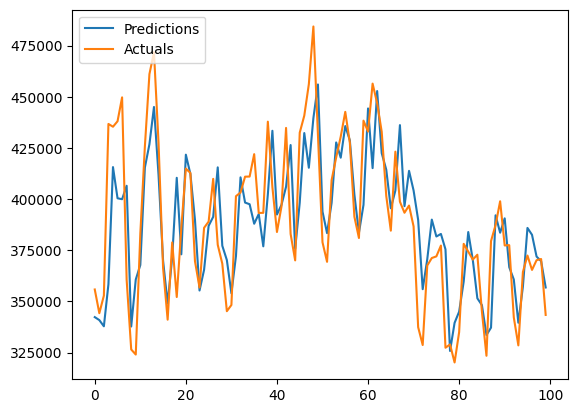

MAPE: 3.95%
RMSE: 20592.85
MAE : 15327.07


Predictions    Actuals
0    342302.65625  355814.96
1    340846.50000  344216.79
2    337812.87500  352812.68
3    358378.40625  436716.40
4    415631.09375  435360.14
..            ...        ...
719  379993.65625  353967.95
720  377894.75000  385900.00
721  393910.40625  411636.83
722  403796.46875  379656.38
723  364600.25000  342930.54

[724 rows x 2 columns]

In [19]:
model1 = load_model('model1.keras')

predictions_plot(model1, X_train, y_train, 0, 100, preprocessor)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


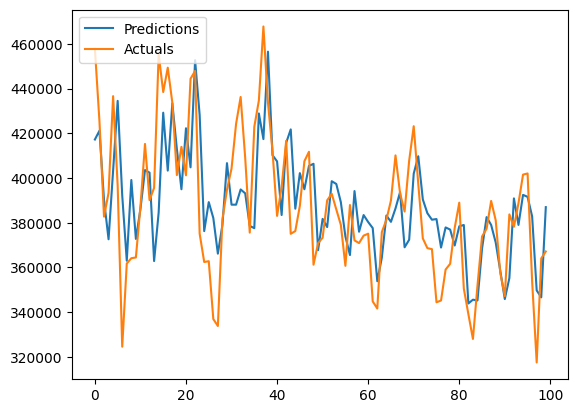

MAPE: 3.79%
RMSE: 18804.87
MAE : 14452.18


Predictions    Actuals
0    417235.50000  457780.70
1    421184.15625  425439.99
2    390266.34375  382741.80
3    372614.78125  393359.12
4    403346.18750  436628.85
..            ...        ...
353  383816.96875  405457.46
354  391056.90625  421027.63
355  378944.50000  407376.71
356  362497.75000  402263.51
357  367768.15625  405023.08

[358 rows x 2 columns]

In [20]:
predictions_plot(model1, X_val, y_val, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


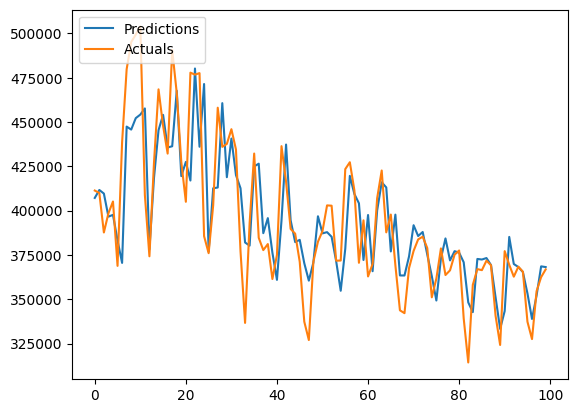

MAPE: 3.88%
RMSE: 19856.41
MAE : 14815.94


Predictions    Actuals
0    407166.34375  411339.27
1    411659.28125  409963.40
2    409635.31250  387672.63
3    396614.59375  398542.65
4    397614.40625  405159.36
..            ...        ...
353  367851.03125  360393.59
354  373284.81250  369325.03
355  359366.43750  371819.56
356  364322.90625  399427.25
357  378183.46875  408178.89

[358 rows x 2 columns]

In [21]:
predictions_plot(model1, X_test, y_test, 0, 100)

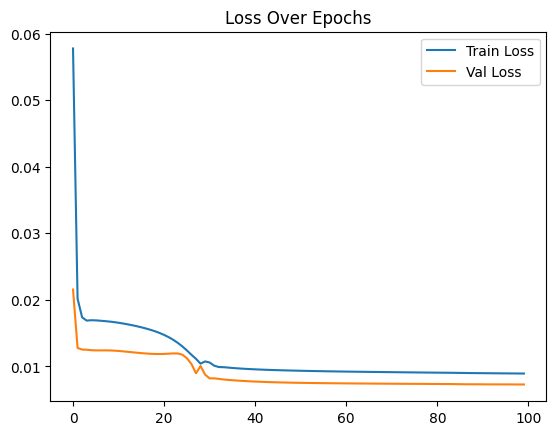

In [22]:
plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

### Model 2 - Overlapping Windows ###

In [11]:
preprocessor = TimeSeriesPreprocessorTVT(demandDF, window_size=7, allow_overlap=True)
preprocessor.split()
preprocessor.scale()
data2 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

X_train2, y_train2 = data2['train']
X_val2, y_val2 = data2['val']
X_test2, y_test2 = data2['test']

i = X_train2.shape[1]
j = X_train2.shape[2]

In [24]:
# set seed
reset_seed()

model2 = Sequential()
model2.add(InputLayer((i, j)))
model2.add(LSTM(64))
model2.add(Dense(8, 'relu'))
model2.add(Dense(1, 'linear'))

model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
cp2 = ModelCheckpoint('model2.keras', save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

history2 = model2.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=100, callbacks=[cp2, es1])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.1047 - root_mean_squared_error: 0.3165 - val_loss: 0.0215 - val_root_mean_squared_error: 0.1466
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0215 - root_mean_squared_error: 0.1464 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1137
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0172 - root_mean_squared_error: 0.1312 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1125
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0167 - root_mean_squared_error: 0.1291 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1124
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0168 - root_mean_squared_error: 0.1294 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1121
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0168 - root_mean_squared_error: 0.1294 - val_loss: 0.0125 - val_root_mean_squared_error: 0.1119
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


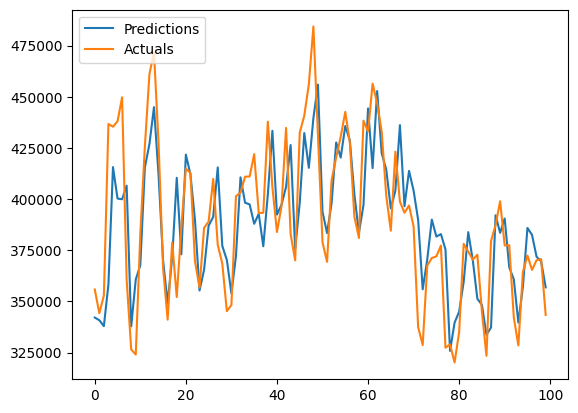

MAPE: 3.95%
RMSE: 20598.50
MAE : 15333.00


Predictions    Actuals
0    342101.03125  355814.96
1    340778.12500  344216.79
2    337891.06250  352812.68
3    358372.37500  436716.40
4    415637.18750  435360.14
..            ...        ...
719  379920.09375  353967.95
720  377916.62500  385900.00
721  393882.87500  411636.83
722  403675.75000  379656.38
723  364464.34375  342930.54

[724 rows x 2 columns]

In [26]:
model2 = load_model('model2.keras')

predictions_plot(model2, X_train2, y_train2, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


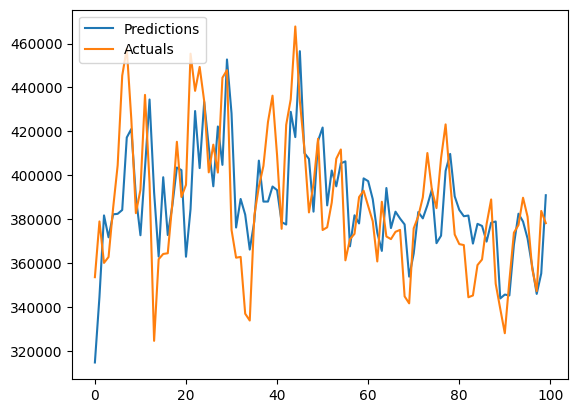

MAPE: 3.85%
RMSE: 19167.60
MAE : 14700.22


Predictions    Actuals
0    314698.93750  353567.49
1    344540.81250  378965.84
2    381708.46875  360065.93
3    371731.62500  362772.07
4    382196.62500  385022.79
..            ...        ...
360  383748.96875  405457.46
361  391001.06250  421027.63
362  378839.43750  407376.71
363  362575.53125  402263.51
364  367915.25000  405023.08

[365 rows x 2 columns]

In [27]:
predictions_plot(model2, X_val2, y_val2, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


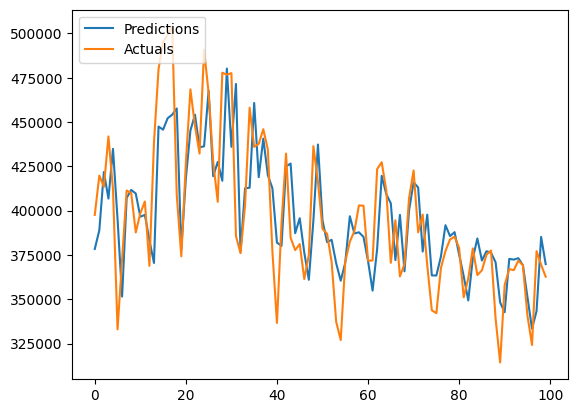

MAPE: 3.95%
RMSE: 20184.99
MAE : 15083.70


Predictions    Actuals
0    378396.40625  397576.81
1    388953.06250  419793.03
2    421779.93750  413402.43
3    406801.46875  441857.98
4    434848.37500  412076.90
..            ...        ...
360  367790.62500  360393.59
361  373224.84375  369325.03
362  359236.28125  371819.56
363  364265.90625  399427.25
364  378174.43750  408178.89

[365 rows x 2 columns]

In [28]:
predictions_plot(model2, X_test2, y_test2, 0, 100)

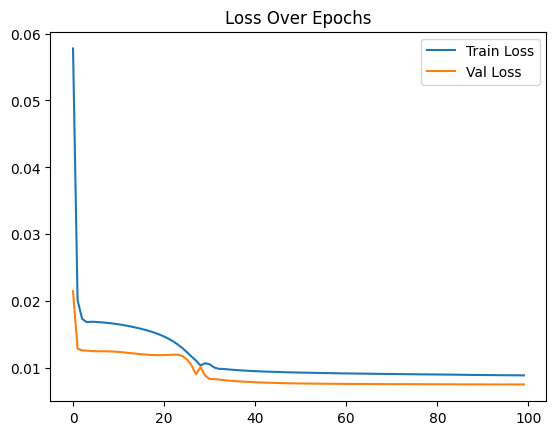

In [29]:
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

## 2. Introducing Temperature... ##

In [12]:
tempDemandDF = test_df[['sum_30_min_demand', 'avg_temp']]

In [31]:
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data3 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

X_train3, y_train3 = data3['train']
X_val3, y_val3 = data3['val']
X_test3, y_test3 = data3['test']

i = X_train3.shape[1]
j = X_train3.shape[2]

### Model 3 ###

In [32]:
# set seed
reset_seed()

model3 = Sequential()
model3.add(InputLayer((i, j)))
model3.add(LSTM(64))
model3.add(Dense(8, 'tanh'))
model3.add(Dense(1, 'linear'))

model3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 64)             │        17,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,681 (69.07 KB)

 Trainable params: 17,681 (69.07 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
cp3 = ModelCheckpoint('model3.keras', save_best_only=True)
model3.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history3 = model3.fit(X_train3, y_train3, validation_data=(X_val3, y_val3), epochs=100, callbacks=[cp3, es2])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.1722 - root_mean_squared_error: 0.4024 - val_loss: 0.0167 - val_root_mean_squared_error: 0.1291
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0196 - root_mean_squared_error: 0.1399 - val_loss: 0.0144 - val_root_mean_squared_error: 0.1201
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0186 - root_mean_squared_error: 0.1363 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1134
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0173 - root_mean_squared_error: 0.1316 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1134
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0171 - root_mean_squared_error: 0.1307 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1142
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0171 - root_mean_squared_error: 0.1307 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1154
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


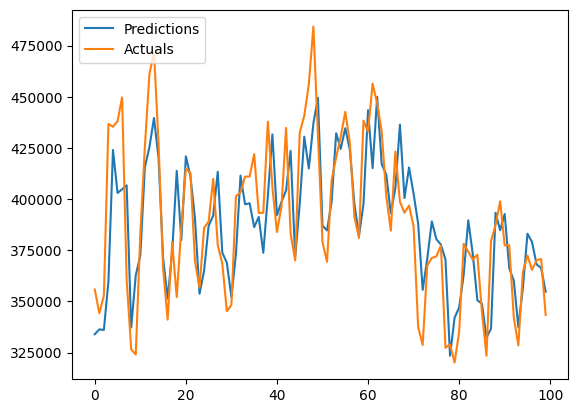

MAPE: 3.88%
RMSE: 20347.03
MAE : 15016.13


Predictions    Actuals
0    333931.15625  355814.96
1    336311.40625  344216.79
2    336032.96875  352812.68
3    359791.62500  436716.40
4    423995.65625  435360.14
..            ...        ...
719  381603.78125  353967.95
720  382570.43750  385900.00
721  400245.37500  411636.83
722  409419.12500  379656.38
723  367902.56250  342930.54

[724 rows x 2 columns]

In [34]:
model3 = load_model('model3.keras')

predictions_plot(model3, X_train3, y_train3, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


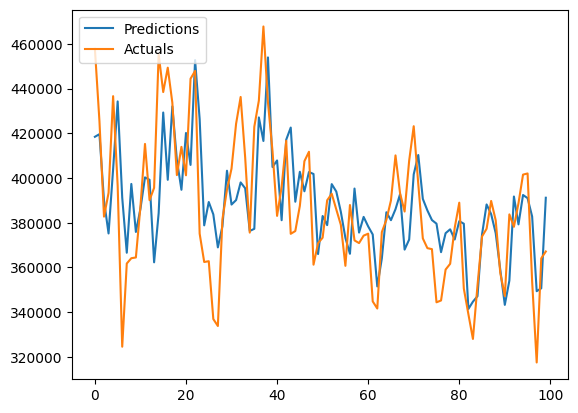

MAPE: 3.75%
RMSE: 18582.11
MAE : 14300.44


Predictions    Actuals
0    418454.34375  457780.70
1    419636.00000  425439.99
2    389903.56250  382741.80
3    375212.81250  393359.12
4    403965.71875  436628.85
..            ...        ...
353  385288.90625  405457.46
354  400646.09375  421027.63
355  391878.78125  407376.71
356  374229.84375  402263.51
357  374452.46875  405023.08

[358 rows x 2 columns]

In [35]:
predictions_plot(model3, X_val3, y_val3, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


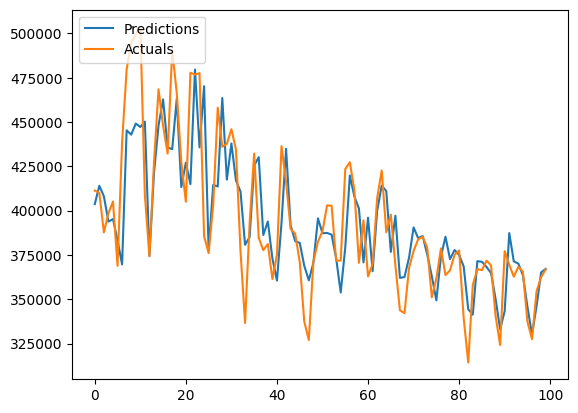

MAPE: 3.91%
RMSE: 20158.42
MAE : 14911.17


Predictions    Actuals
0    403639.31250  411339.27
1    414014.34375  409963.40
2    408116.81250  387672.63
3    393797.15625  398542.65
4    395265.37500  405159.36
..            ...        ...
353  370514.06250  360393.59
354  380443.87500  369325.03
355  372350.56250  371819.56
356  376220.59375  399427.25
357  388634.56250  408178.89

[358 rows x 2 columns]

In [36]:
predictions_plot(model3, X_test3, y_test3, 0, 100)

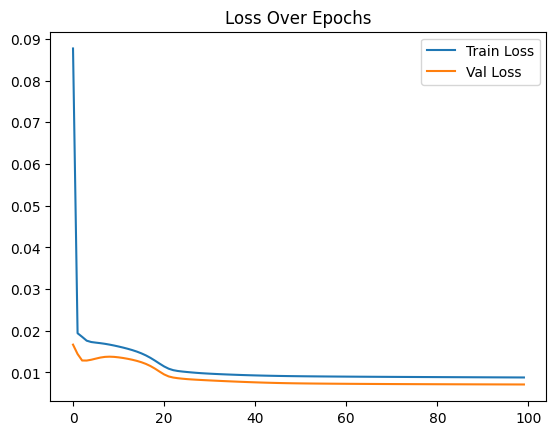

In [37]:
plt.plot(history3.history['loss'], label='Train Loss')
plt.plot(history3.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

## Feature Analysis ##

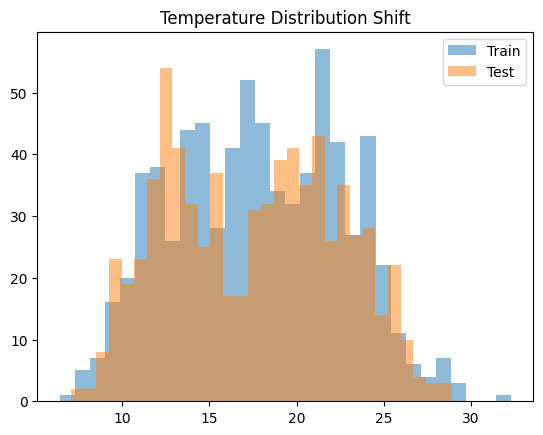

In [38]:
plt.hist(test_df['avg_temp'][0:731], bins=30, alpha=0.5, label='Train')
plt.hist(test_df['avg_temp'][732:], bins=30, alpha=0.5, label='Test')
plt.legend()
plt.title("Temperature Distribution Shift")
plt.show()

## Testing Temp Measures ##

In [13]:
tempDemandDF2 = test_df[['sum_30_min_demand', 'avg_temp', 'min_temp', 'max_temp']]

## Model 4 ##

In [40]:
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF2, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data4 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

X_train4, y_train4 = data4['train']
X_val4, y_val4 = data4['val']
X_test4, y_test4 = data4['test']

i = X_train4.shape[1]
j = X_train4.shape[2]

In [41]:
# set seed
reset_seed()

model4 = Sequential()
model4.add(InputLayer((i, j)))
model4.add(LSTM(64))
model4.add(Dense(8, 'tanh'))
model4.add(Dense(1, 'linear'))

model4.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 64)             │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,193 (71.07 KB)

 Trainable params: 18,193 (71.07 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
cp4 = ModelCheckpoint('model4.keras', save_best_only=True)
model4.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history4 = model4.fit(X_train4, y_train4, validation_data=(X_val4, y_val4), epochs=100, callbacks=[cp4, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.1472 - root_mean_squared_error: 0.3722 - val_loss: 0.0260 - val_root_mean_squared_error: 0.1613
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0245 - root_mean_squared_error: 0.1561 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1135
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0171 - root_mean_squared_error: 0.1306 - val_loss: 0.0140 - val_root_mean_squared_error: 0.1182
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0173 - root_mean_squared_error: 0.1313 - val_loss: 0.0143 - val_root_mean_squared_error: 0.1195
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0172 - root_mean_squared_error: 0.1311 - val_loss: 0.0137 - val_root_mean_squared_error: 0.1168
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0166 - root_mean_squared_error: 0.1289 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1139
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


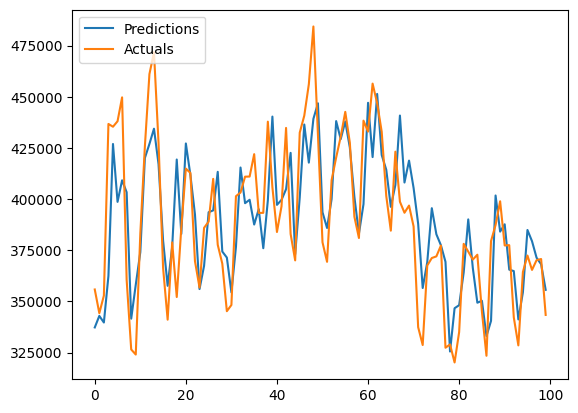

MAPE: 4.03%
RMSE: 20646.36
MAE : 15484.72


Predictions    Actuals
0    337259.40625  355814.96
1    342896.93750  344216.79
2    339665.84375  352812.68
3    362443.15625  436716.40
4    426929.90625  435360.14
..            ...        ...
719  378976.06250  353967.95
720  389286.43750  385900.00
721  398294.37500  411636.83
722  397648.09375  379656.38
723  354863.12500  342930.54

[724 rows x 2 columns]

In [43]:
model4 = load_model('model4.keras')

predictions_plot(model4, X_train4, y_train4, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


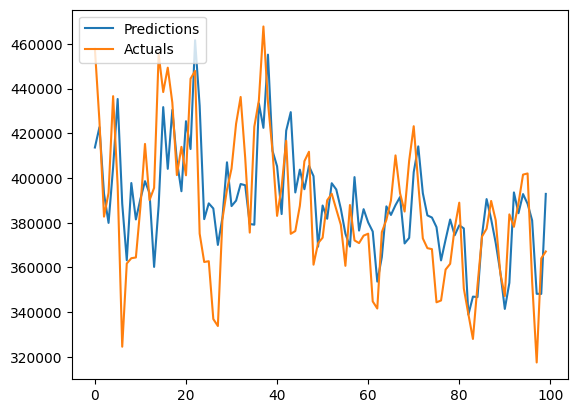

MAPE: 3.93%
RMSE: 19131.72
MAE : 14890.63


Predictions    Actuals
0    413658.03125  457780.70
1    422743.59375  425439.99
2    393023.93750  382741.80
3    379936.40625  393359.12
4    404825.15625  436628.85
..            ...        ...
353  384506.15625  405457.46
354  398237.00000  421027.63
355  387527.21875  407376.71
356  372116.50000  402263.51
357  375028.75000  405023.08

[358 rows x 2 columns]

In [44]:
predictions_plot(model4, X_val4, y_val4, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


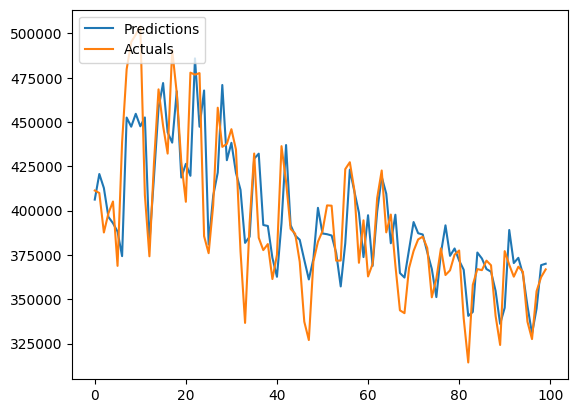

MAPE: 4.07%
RMSE: 20357.72
MAE : 15439.46


Predictions    Actuals
0    406237.28125  411339.27
1    420665.21875  409963.40
2    412763.78125  387672.63
3    396434.56250  398542.65
4    392919.15625  405159.36
..            ...        ...
353  371225.40625  360393.59
354  376527.34375  369325.03
355  369287.90625  371819.56
356  368646.65625  399427.25
357  382756.40625  408178.89

[358 rows x 2 columns]

In [45]:
predictions_plot(model4, X_test4, y_test4, 0, 100)

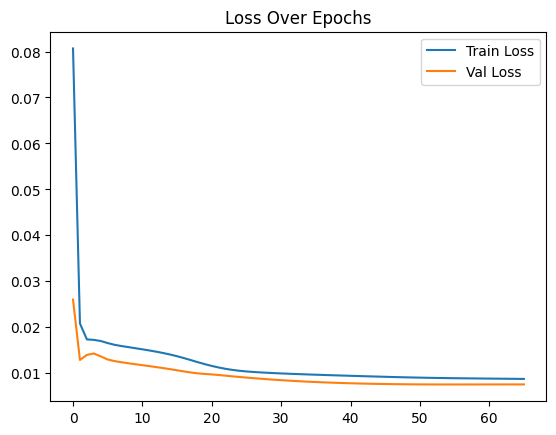

In [46]:
plt.plot(history4.history['loss'], label='Train Loss')
plt.plot(history4.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

## Model 5 ##

In [14]:
test_df['temp_range'] = test_df['max_temp'] - test_df['min_temp']

tempDemandDF3 = test_df[['sum_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'temp_range']].copy()
tempDemandDF3.drop(['min_temp', 'max_temp'], axis=1, inplace=True)

In [48]:
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF3, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data5 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

X_train5, y_train5 = data5['train']
X_val5, y_val5 = data5['val']
X_test5, y_test5 = data5['test']

i = X_train5.shape[1]
j = X_train5.shape[2]

In [49]:
# set seed
reset_seed()

model5 = Sequential()
model5.add(InputLayer((i, j)))
model5.add(LSTM(64))
model5.add(Dense(8, 'tanh'))
model5.add(Dense(1, 'linear'))

model5.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 64)             │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,937 (70.07 KB)

 Trainable params: 17,937 (70.07 KB)

 Non-trainable params: 0 (0.00 B)

In [50]:
cp5 = ModelCheckpoint('model5.keras', save_best_only=True)
model5.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history5 = model5.fit(X_train5, y_train5, validation_data=(X_val5, y_val5), epochs=100, callbacks=[cp5, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.1555 - root_mean_squared_error: 0.3816 - val_loss: 0.0173 - val_root_mean_squared_error: 0.1315
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0230 - root_mean_squared_error: 0.1515 - val_loss: 0.0140 - val_root_mean_squared_error: 0.1183
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0174 - root_mean_squared_error: 0.1317 - val_loss: 0.0145 - val_root_mean_squared_error: 0.1205
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0175 - root_mean_squared_error: 0.1322 - val_loss: 0.0148 - val_root_mean_squared_error: 0.1218
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0173 - root_mean_squared_error: 0.1316 - val_loss: 0.0144 - val_root_mean_squared_error: 0.1200
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0169 - root_mean_squared_error: 0.1299 - val_loss: 0.0139 - val_root_mean_squared_error: 0.1181
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - lo

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


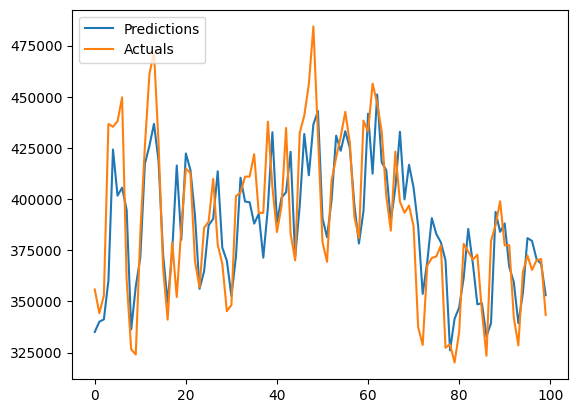

MAPE: 3.84%
RMSE: 20094.63
MAE : 14885.44


Predictions    Actuals
0    335052.00000  355814.96
1    340041.93750  344216.79
2    341199.31250  352812.68
3    360207.15625  436716.40
4    424202.59375  435360.14
..            ...        ...
719  376773.25000  353967.95
720  384869.09375  385900.00
721  398307.50000  411636.83
722  404984.09375  379656.38
723  363104.81250  342930.54

[724 rows x 2 columns]

In [51]:
model5 = load_model('model5.keras')

predictions_plot(model5, X_train5, y_train5, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


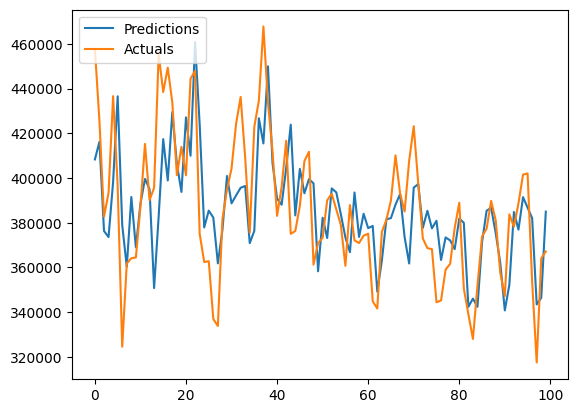

MAPE: 3.69%
RMSE: 18468.21
MAE : 14102.43


Predictions    Actuals
0    408334.65625  457780.70
1    416228.09375  425439.99
2    376314.15625  382741.80
3    373603.78125  393359.12
4    398321.50000  436628.85
..            ...        ...
353  385229.37500  405457.46
354  401122.62500  421027.63
355  392938.68750  407376.71
356  369473.62500  402263.51
357  364469.21875  405023.08

[358 rows x 2 columns]

In [ ]:
predictions_plot(model5, X_val5, y_val5, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


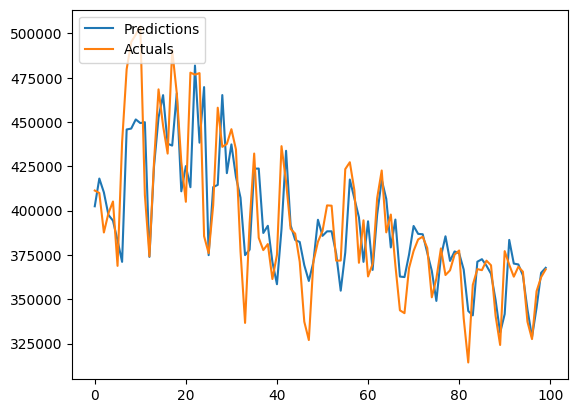

MAPE: 3.84%
RMSE: 19829.26
MAE : 14700.98


Predictions    Actuals
0    402458.03125  411339.27
1    418103.31250  409963.40
2    410288.25000  387672.63
3    397617.62500  398542.65
4    394334.53125  405159.36
..            ...        ...
353  367932.21875  360393.59
354  377505.03125  369325.03
355  368858.75000  371819.56
356  371809.25000  399427.25
357  384476.59375  408178.89

[358 rows x 2 columns]

In [52]:
predictions_plot(model5, X_test5, y_test5, 0, 100)

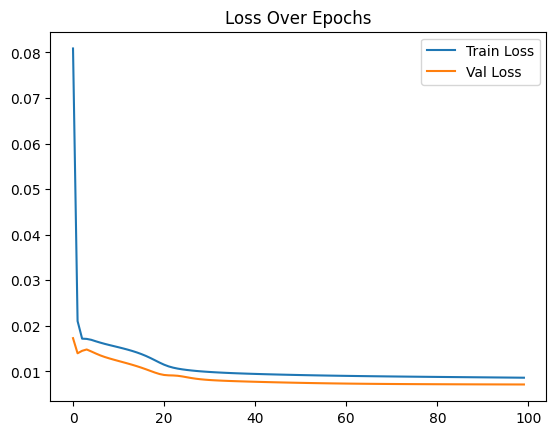

In [53]:
plt.plot(history5.history['loss'], label='Train Loss')
plt.plot(history5.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

## Model 6 ##

In [15]:
tempDemandDF4 = test_df[['sum_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'temp_range']].copy()

In [55]:
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF4, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data6 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

X_train6, y_train6 = data6['train']
X_val6, y_val6 = data6['val']
X_test6, y_test6 = data6['test']

i = X_train6.shape[1]
j = X_train6.shape[2]

In [56]:
# set seed
reset_seed()

model6 = Sequential()
model6.add(InputLayer((i, j)))
model6.add(LSTM(64))
model6.add(Dense(8, 'tanh'))
model6.add(Dense(1, 'linear'))

model6.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,449 (72.07 KB)

 Trainable params: 18,449 (72.07 KB)

 Non-trainable params: 0 (0.00 B)

In [57]:
cp6 = ModelCheckpoint('model6.keras', save_best_only=True)
model6.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history6 = model6.fit(X_train6, y_train6, validation_data=(X_val6, y_val6), epochs=100, callbacks=[cp6, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.1797 - root_mean_squared_error: 0.4094 - val_loss: 0.0230 - val_root_mean_squared_error: 0.1517
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0239 - root_mean_squared_error: 0.1542 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1138
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0172 - root_mean_squared_error: 0.1312 - val_loss: 0.0140 - val_root_mean_squared_error: 0.1183
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0173 - root_mean_squared_error: 0.1315 - val_loss: 0.0140 - val_root_mean_squared_error: 0.1185
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0170 - root_mean_squared_error: 0.1302 - val_loss: 0.0132 - val_root_mean_squared_error: 0.1148
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0163 - root_mean_squared_error: 0.1278 - val_loss: 0.0128 - val_root_mean_squared_error: 0.1133
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


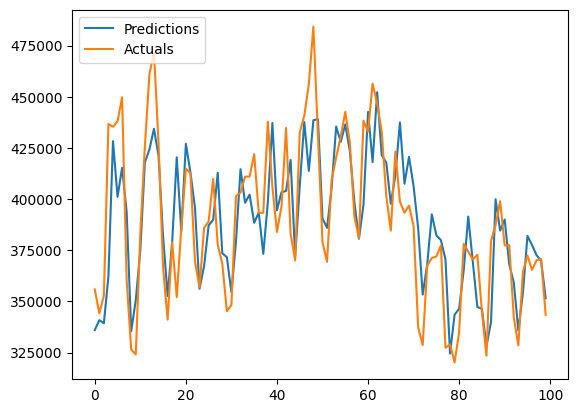

MAPE: 3.81%
RMSE: 19750.49
MAE : 14669.21


Predictions    Actuals
0    335970.12500  355814.96
1    340818.37500  344216.79
2    339300.90625  352812.68
3    362299.15625  436716.40
4    428307.25000  435360.14
..            ...        ...
719  377808.06250  353967.95
720  387943.09375  385900.00
721  397867.34375  411636.83
722  401806.78125  379656.38
723  357333.50000  342930.54

[724 rows x 2 columns]

In [58]:
model6 = load_model('model6.keras')
predictions_plot(model6, X_train6, y_train6, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


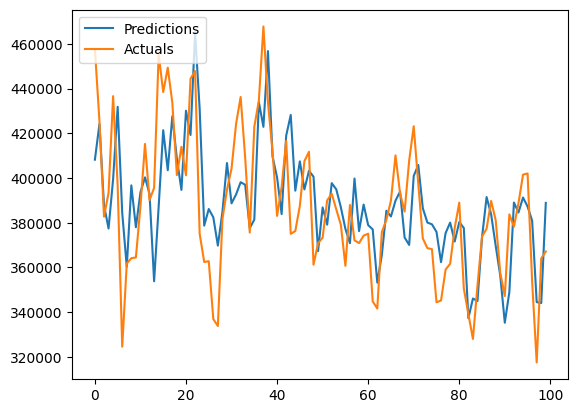

MAPE: 3.79%
RMSE: 18651.60
MAE : 14401.40


Predictions    Actuals
0    408211.43750  457780.70
1    424165.00000  425439.99
2    387831.31250  382741.80
3    377428.21875  393359.12
4    399516.40625  436628.85
..            ...        ...
353  385819.43750  405457.46
354  401172.59375  421027.63
355  388524.12500  407376.71
356  369179.15625  402263.51
357  370604.40625  405023.08

[358 rows x 2 columns]

In [59]:
predictions_plot(model6, X_val6, y_val6, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


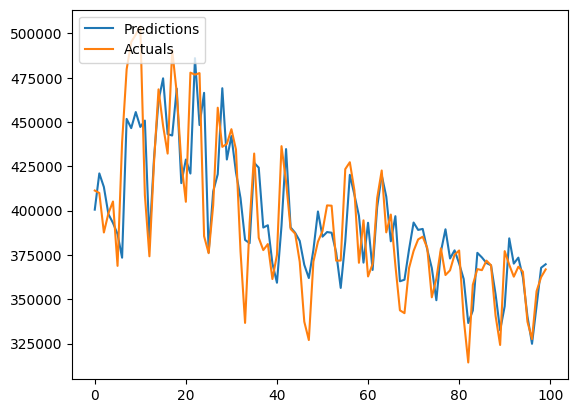

MAPE: 3.88%
RMSE: 19642.82
MAE : 14757.63


Predictions    Actuals
0    400561.40625  411339.27
1    421003.21875  409963.40
2    413328.31250  387672.63
3    398009.18750  398542.65
4    393058.09375  405159.36
..            ...        ...
353  372959.87500  360393.59
354  377627.18750  369325.03
355  370034.03125  371819.56
356  370727.56250  399427.25
357  381877.34375  408178.89

[358 rows x 2 columns]

In [60]:
predictions_plot(model6, X_test6, y_test6, 0, 100)

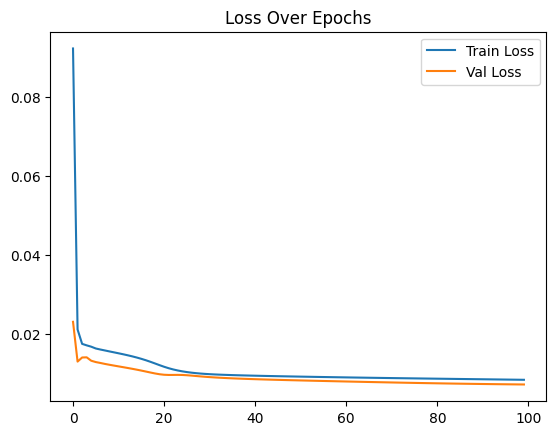

In [61]:
plt.plot(history6.history['loss'], label='Train Loss')
plt.plot(history6.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

## Increase Window Size to 10 ##

## Model 7 ##

In [62]:
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF4, window_size=10, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data7 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

X_train7, y_train7 = data7['train']
X_val7, y_val7 = data7['val']
X_test7, y_test7 = data7['test']

i = X_train7.shape[1]
j = X_train7.shape[2]

In [63]:
# set seed
reset_seed()

model7 = Sequential()
model7.add(InputLayer((i, j)))
model7.add(LSTM(64))
model7.add(Dense(8, 'tanh'))
model7.add(Dense(1, 'linear'))

model7.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,449 (72.07 KB)

 Trainable params: 18,449 (72.07 KB)

 Non-trainable params: 0 (0.00 B)

In [64]:
cp7 = ModelCheckpoint('model7.keras', save_best_only=True)
model7.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history7 = model7.fit(X_train7, y_train7, validation_data=(X_val7, y_val7), epochs=100, callbacks=[cp7, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.1791 - root_mean_squared_error: 0.4084 - val_loss: 0.0273 - val_root_mean_squared_error: 0.1654
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0253 - root_mean_squared_error: 0.1588 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1176
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0197 - root_mean_squared_error: 0.1402 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1135
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0176 - root_mean_squared_error: 0.1324 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1136
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0168 - root_mean_squared_error: 0.1296 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1134
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0164 - root_mean_squared_error: 0.1278 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1121
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


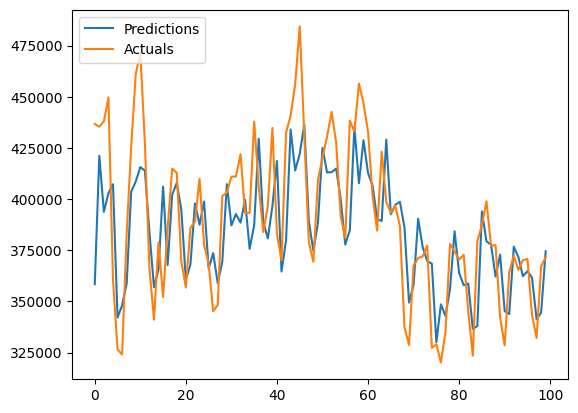

MAPE: 4.36%
RMSE: 22198.37
MAE : 16965.80


Predictions    Actuals
0    358428.59375  436716.40
1    421172.06250  435360.14
2    393773.25000  438032.58
3    402871.03125  449709.69
4    407260.65625  360495.64
..            ...        ...
716  366752.93750  353967.95
717  389462.46875  385900.00
718  390353.31250  411636.83
719  390766.06250  379656.38
720  354504.37500  342930.54

[721 rows x 2 columns]

In [65]:
model7 = load_model('model7.keras')

predictions_plot(model7, X_train7, y_train7, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


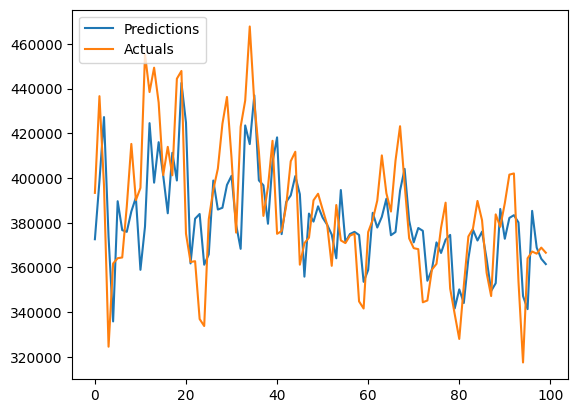

MAPE: 4.01%
RMSE: 19575.57
MAE : 15336.93


Predictions    Actuals
0    372626.28125  393359.12
1    398657.65625  436628.85
2    427272.53125  396547.46
3    373639.12500  324557.19
4    335855.59375  361764.59
..            ...        ...
350  372341.84375  405457.46
351  397148.25000  421027.63
352  389428.00000  407376.71
353  372422.50000  402263.51
354  375484.25000  405023.08

[355 rows x 2 columns]

In [66]:
predictions_plot(model7, X_val7, y_val7, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


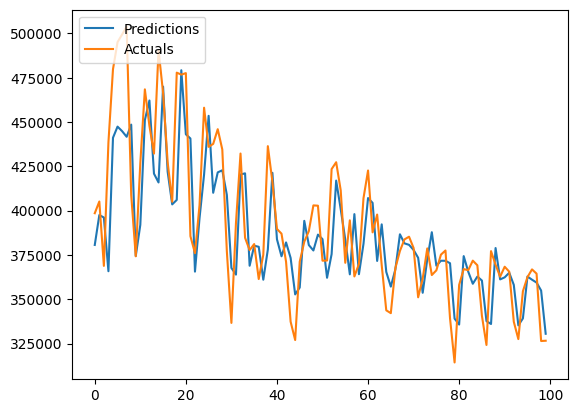

MAPE: 4.31%
RMSE: 21372.01
MAE : 16535.65


Predictions    Actuals
0    380648.78125  398542.65
1    397498.12500  405159.36
2    396122.90625  368840.45
3    365822.09375  438517.06
4    441112.71875  479784.41
..            ...        ...
350  360183.34375  360393.59
351  372562.34375  369325.03
352  368311.28125  371819.56
353  365222.18750  399427.25
354  386056.71875  408178.89

[355 rows x 2 columns]

In [67]:
predictions_plot(model7, X_test7, y_test7, 0, 100)

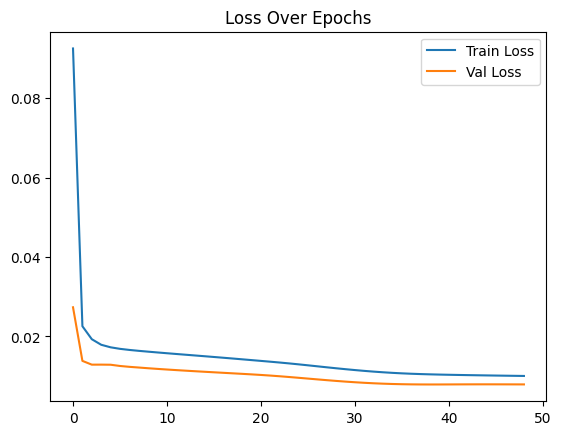

In [68]:
plt.plot(history7.history['loss'], label='Train Loss')
plt.plot(history7.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

## Model 8 - Decrease Window Size to 5 ##

In [69]:
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF4, window_size=5, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data8 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

X_train8, y_train8 = data8['train']
X_val8, y_val8 = data8['val']
X_test8, y_test8 = data8['test']

i = X_train8.shape[1]
j = X_train8.shape[2]

In [70]:
# set seed
reset_seed()

model8 = Sequential()
model8.add(InputLayer((i, j)))
model8.add(LSTM(64))
model8.add(Dense(8, 'tanh'))
model8.add(Dense(1, 'linear'))

model8.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,449 (72.07 KB)

 Trainable params: 18,449 (72.07 KB)

 Non-trainable params: 0 (0.00 B)

In [71]:
cp8 = ModelCheckpoint('model8.keras', save_best_only=True)
model8.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])
history8 = model8.fit(X_train8, y_train8, validation_data=(X_val8, y_val8), epochs=100, callbacks=[cp8, es1])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.1737 - root_mean_squared_error: 0.4058 - val_loss: 0.0220 - val_root_mean_squared_error: 0.1484
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0266 - root_mean_squared_error: 0.1630 - val_loss: 0.0144 - val_root_mean_squared_error: 0.1199
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0193 - root_mean_squared_error: 0.1388 - val_loss: 0.0132 - val_root_mean_squared_error: 0.1147
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0179 - root_mean_squared_error: 0.1337 - val_loss: 0.0131 - val_root_mean_squared_error: 0.1147
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0172 - root_mean_squared_error: 0.1309 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1140
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0167 - root_mean_squared_error: 0.1291 - val_loss: 0.0128 - val_root_mean_squared_error: 0.1129
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - los

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


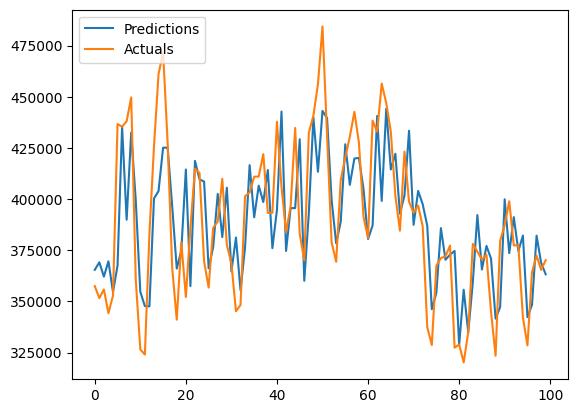

MAPE: 4.33%
RMSE: 21901.51
MAE : 16634.86


Predictions    Actuals
0    365407.78125  357451.06
1    369092.12500  351570.67
2    362099.56250  355814.96
3    369579.28125  344216.79
4    354582.00000  352812.68
..            ...        ...
721  355499.96875  353967.95
722  376429.71875  385900.00
723  390710.15625  411636.83
724  403810.75000  379656.38
725  358735.12500  342930.54

[726 rows x 2 columns]

In [72]:
model8 = load_model('model8.keras')

predictions_plot(model8, X_train8, y_train8, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


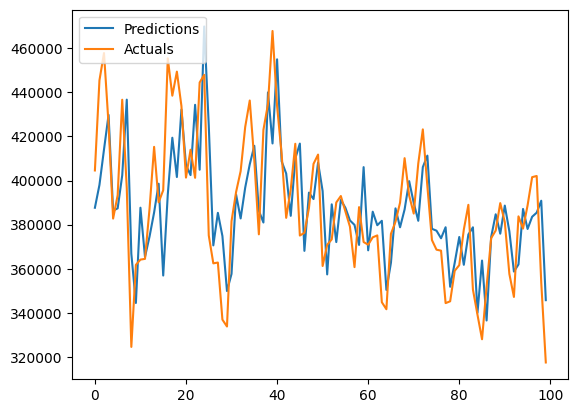

MAPE: 4.10%
RMSE: 19656.12
MAE : 15560.37


Predictions    Actuals
0    387649.00000  404557.93
1    398004.31250  445401.38
2    414060.21875  457780.70
3    429752.15625  425439.99
4    386340.65625  382741.80
..            ...        ...
355  373446.34375  405457.46
356  396861.12500  421027.63
357  395573.18750  407376.71
358  383391.90625  402263.51
359  387092.84375  405023.08

[360 rows x 2 columns]

In [73]:
predictions_plot(model8, X_val8, y_val8, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


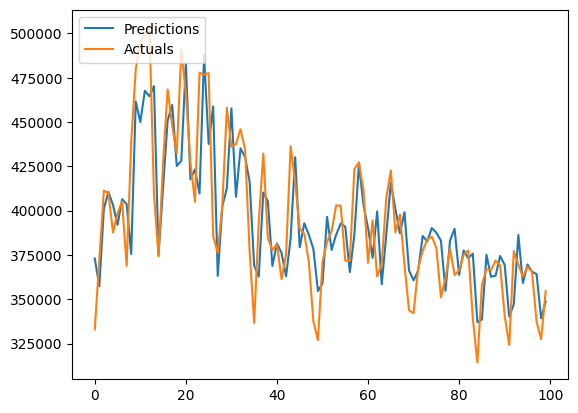

MAPE: 4.22%
RMSE: 20711.86
MAE : 15901.81


Predictions    Actuals
0    373017.28125  333009.61
1    357342.00000  372457.04
2    401183.34375  411339.27
3    410445.34375  409963.40
4    403227.43750  387672.63
..            ...        ...
355  371450.40625  360393.59
356  373427.03125  369325.03
357  375005.53125  371819.56
358  374088.34375  399427.25
359  397706.00000  408178.89

[360 rows x 2 columns]

In [74]:
predictions_plot(model8, X_test8, y_test8, 0, 100)

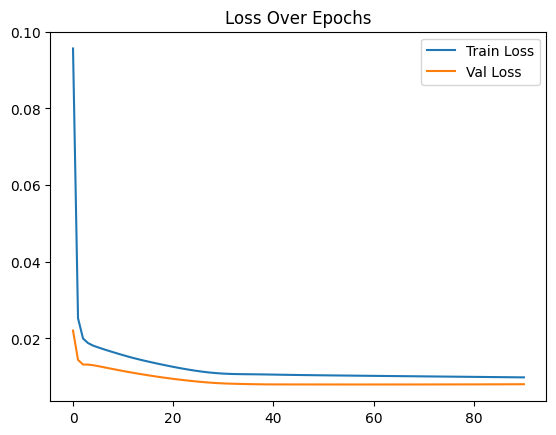

In [75]:
plt.plot(history8.history['loss'], label='Train Loss')
plt.plot(history8.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

## Model 9 - Increase Window Size to 14 ##

In [76]:
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF4, window_size=14, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data9 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

X_train9, y_train9 = data9['train']
X_val9, y_val9 = data9['val']
X_test9, y_test9 = data9['test']

i = X_train9.shape[1]
j = X_train9.shape[2]

In [77]:
# set seed
reset_seed()

model9 = Sequential()
model9.add(InputLayer((i, j)))
model9.add(LSTM(64))
model9.add(Dense(8, 'tanh'))
model9.add(Dense(1, 'linear'))

model9.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,449 (72.07 KB)

 Trainable params: 18,449 (72.07 KB)

 Non-trainable params: 0 (0.00 B)

In [78]:
cp9 = ModelCheckpoint('model9.keras', save_best_only=True)
model9.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history9 = model9.fit(X_train9, y_train9, validation_data=(X_val9, y_val9), epochs=100, callbacks=[cp9, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.1865 - root_mean_squared_error: 0.4162 - val_loss: 0.0215 - val_root_mean_squared_error: 0.1466
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0234 - root_mean_squared_error: 0.1528 - val_loss: 0.0140 - val_root_mean_squared_error: 0.1182
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0195 - root_mean_squared_error: 0.1394 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1126
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0180 - root_mean_squared_error: 0.1341 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1112
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0177 - root_mean_squared_error: 0.1328 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1102
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0174 - root_mean_squared_error: 0.1318 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1091
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - lo

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


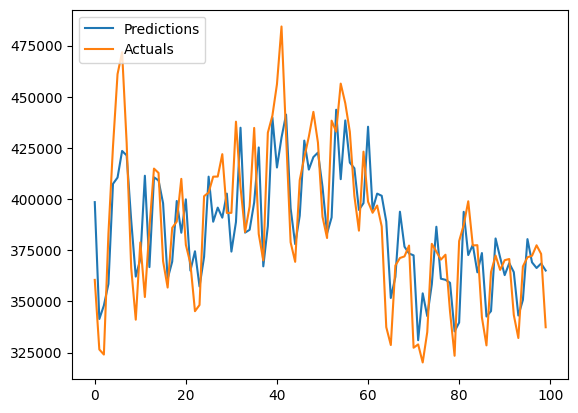

MAPE: 4.24%
RMSE: 21398.26
MAE : 16342.18


Predictions    Actuals
0    398502.90625  360495.64
1    341374.65625  326492.10
2    347980.43750  324006.75
3    358521.15625  383092.64
4    407436.84375  425665.84
..            ...        ...
712  368271.43750  353967.95
713  388883.28125  385900.00
714  393075.96875  411636.83
715  396772.50000  379656.38
716  356351.03125  342930.54

[717 rows x 2 columns]

In [79]:
model9 = load_model('model9.keras')

predictions_plot(model9, X_train9, y_train9, 0, 100)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


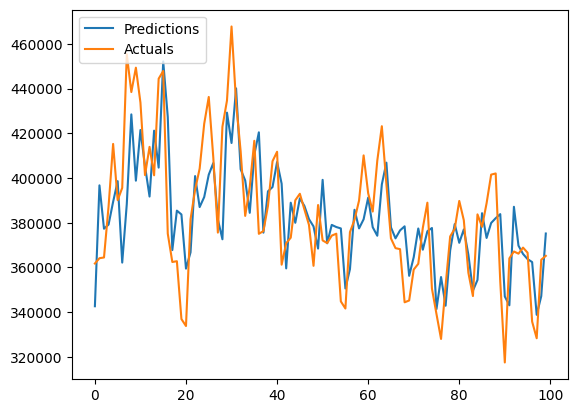

MAPE: 3.91%
RMSE: 18855.12
MAE : 14854.93


Predictions    Actuals
0    342650.15625  361764.59
1    396733.03125  364142.94
2    377337.00000  364469.53
3    379173.00000  387246.97
4    389341.06250  415263.41
..            ...        ...
346  373960.46875  405457.46
347  395908.93750  421027.63
348  389039.59375  407376.71
349  373138.62500  402263.51
350  377186.75000  405023.08

[351 rows x 2 columns]

In [80]:
predictions_plot(model9, X_val9, y_val9, 0, 100)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


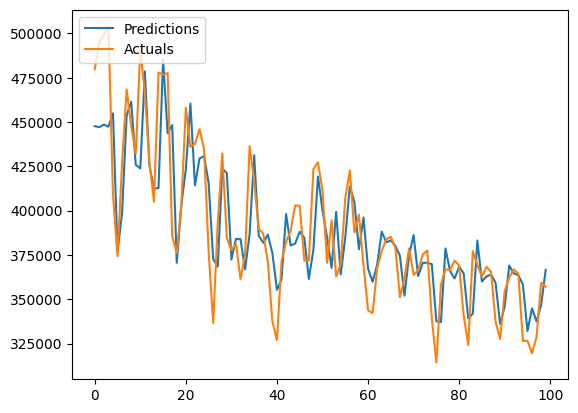

MAPE: 4.16%
RMSE: 20376.72
MAE : 15773.97


Predictions    Actuals
0    447667.96875  479784.41
1    447078.12500  495056.95
2    448544.65625  499342.29
3    447321.50000  503885.71
4    454912.84375  408832.77
..            ...        ...
346  365547.62500  360393.59
347  374197.15625  369325.03
348  368655.53125  371819.56
349  365515.90625  399427.25
350  386250.28125  408178.89

[351 rows x 2 columns]

In [81]:
predictions_plot(model9, X_test9, y_test9, 0, 100)

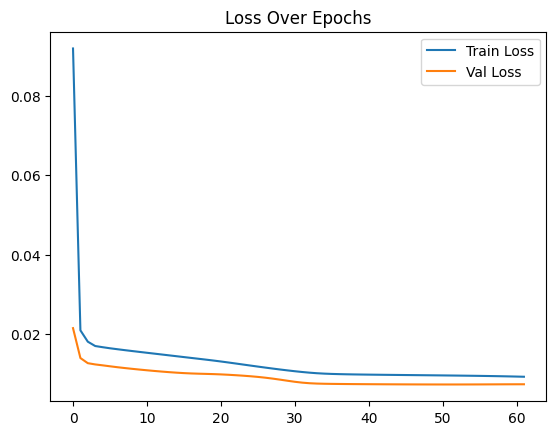

In [82]:
plt.plot(history9.history['loss'], label='Train Loss')
plt.plot(history9.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

## Model 10 - Add CDD/HDD ##

In [16]:
tempDemandDF5 = test_df[['sum_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h','temp_range']].copy()

In [84]:
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF5, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data10 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

X_train10, y_train10 = data10['train']
X_val10, y_val10 = data10['val']
X_test10, y_test10 = data10['test']

i = X_train10.shape[1]
j = X_train10.shape[2]

In [85]:
# set seed
reset_seed()

model10 = Sequential()
model10.add(InputLayer((i, j)))
model10.add(LSTM(64))
model10.add(Dense(8, 'tanh'))
model10.add(Dense(1, 'linear'))

model10.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 64)             │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,961 (74.07 KB)

 Trainable params: 18,961 (74.07 KB)

 Non-trainable params: 0 (0.00 B)

In [86]:
cp10 = ModelCheckpoint('model10.keras', save_best_only=True)
model10.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history10 = model10.fit(X_train10, y_train10, validation_data=(X_val10, y_val10), epochs=100, callbacks=[cp10, es2])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.1302 - root_mean_squared_error: 0.3493 - val_loss: 0.0166 - val_root_mean_squared_error: 0.1289
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0211 - root_mean_squared_error: 0.1451 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1114
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0165 - root_mean_squared_error: 0.1284 - val_loss: 0.0144 - val_root_mean_squared_error: 0.1199
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0167 - root_mean_squared_error: 0.1291 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1174
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0157 - root_mean_squared_error: 0.1254 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1127
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0151 - root_mean_squared_error: 0.1229 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1114
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - los

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


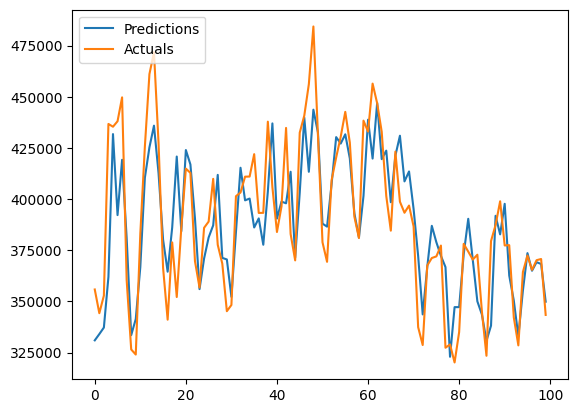

MAPE: 3.52%
RMSE: 18783.67
MAE : 13574.65


Predictions    Actuals
0    330947.12500  355814.96
1    334005.96875  344216.79
2    337214.53125  352812.68
3    361966.06250  436716.40
4    431763.90625  435360.14
..            ...        ...
719  378818.68750  353967.95
720  390952.75000  385900.00
721  395349.68750  411636.83
722  393282.53125  379656.38
723  350355.84375  342930.54

[724 rows x 2 columns]

In [87]:
model10 = load_model('model10.keras')
predictions_plot(model10, X_train10, y_train10, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


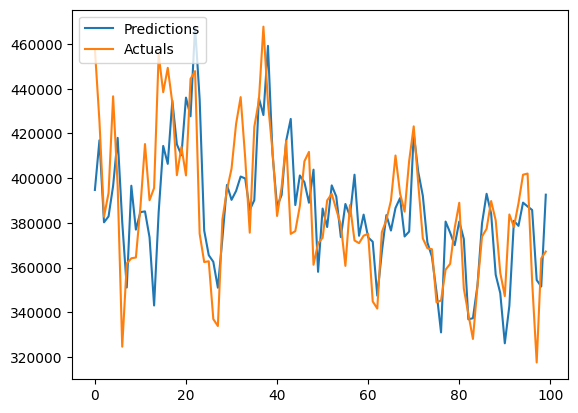

MAPE: 3.64%
RMSE: 18298.75
MAE : 13915.70


Predictions    Actuals
0    394721.21875  457780.70
1    416954.06250  425439.99
2    380229.46875  382741.80
3    382876.18750  393359.12
4    396533.81250  436628.85
..            ...        ...
353  383044.78125  405457.46
354  396981.68750  421027.63
355  396945.50000  407376.71
356  373200.81250  402263.51
357  369484.40625  405023.08

[358 rows x 2 columns]

In [88]:
predictions_plot(model10, X_val10, y_val10, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


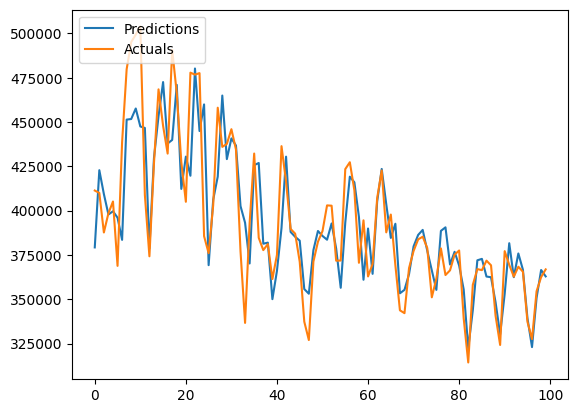

MAPE: 3.86%
RMSE: 19571.43
MAE : 14682.51


Predictions    Actuals
0    379252.25000  411339.27
1    422819.46875  409963.40
2    409350.53125  387672.63
3    397824.15625  398542.65
4    399643.34375  405159.36
..            ...        ...
353  381414.75000  360393.59
354  381131.65625  369325.03
355  383195.90625  371819.56
356  378972.28125  399427.25
357  368775.68750  408178.89

[358 rows x 2 columns]

In [89]:
predictions_plot(model10, X_test10, y_test10, 0, 100)

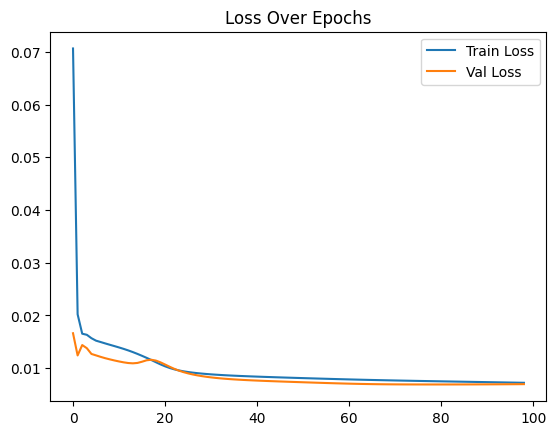

In [90]:
plt.plot(history10.history['loss'], label='Train Loss')
plt.plot(history10.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

## Model 11 - Remove Avg Temp from Model 10 ##

In [17]:
tempDemandDF6 = test_df[['sum_30_min_demand', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h','temp_range']].copy()

In [92]:
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF6, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data11 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

X_train11, y_train11 = data11['train']
X_val11, y_val11 = data11['val']
X_test11, y_test11 = data11['test']

i = X_train11.shape[1]
j = X_train11.shape[2]

In [93]:
# set seed
reset_seed()

model11 = Sequential()
model11.add(InputLayer((i, j)))
model11.add(LSTM(64))
model11.add(Dense(8, 'tanh'))
model11.add(Dense(1, 'linear'))

model11.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 64)             │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,705 (73.07 KB)

 Trainable params: 18,705 (73.07 KB)

 Non-trainable params: 0 (0.00 B)

In [94]:
cp11 = ModelCheckpoint('model11.keras', save_best_only=True)
model11.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history11 = model11.fit(X_train11, y_train11, validation_data=(X_val11, y_val11), epochs=100, callbacks=[cp11, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.1362 - root_mean_squared_error: 0.3570 - val_loss: 0.0180 - val_root_mean_squared_error: 0.1340
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0224 - root_mean_squared_error: 0.1496 - val_loss: 0.0134 - val_root_mean_squared_error: 0.1157
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0163 - root_mean_squared_error: 0.1276 - val_loss: 0.0145 - val_root_mean_squared_error: 0.1205
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0165 - root_mean_squared_error: 0.1285 - val_loss: 0.0146 - val_root_mean_squared_error: 0.1210
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0160 - root_mean_squared_error: 0.1266 - val_loss: 0.0140 - val_root_mean_squared_error: 0.1182
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0155 - root_mean_squared_error: 0.1246 - val_loss: 0.0135 - val_root_mean_squared_error: 0.1161
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


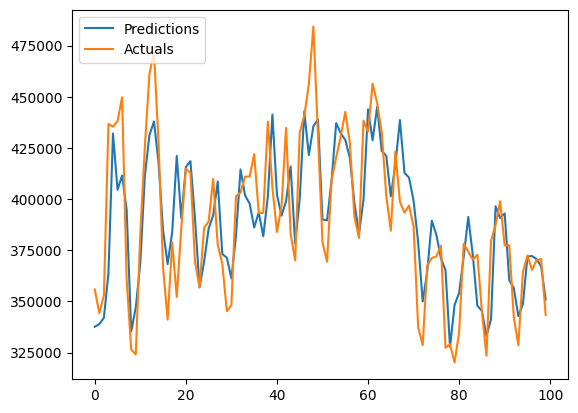

MAPE: 3.82%
RMSE: 19723.50
MAE : 14643.15


Predictions    Actuals
0    337583.75000  355814.96
1    338866.59375  344216.79
2    341956.62500  352812.68
3    363608.15625  436716.40
4    432015.12500  435360.14
..            ...        ...
719  376761.53125  353967.95
720  394306.59375  385900.00
721  396645.25000  411636.83
722  394507.71875  379656.38
723  354853.40625  342930.54

[724 rows x 2 columns]

In [95]:
model11 = load_model('model11.keras')

predictions_plot(model11, X_train11, y_train11, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


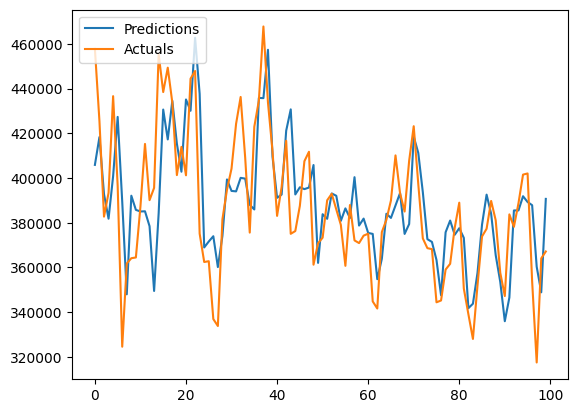

MAPE: 3.78%
RMSE: 18608.76
MAE : 14333.01


Predictions    Actuals
0    405879.46875  457780.70
1    418321.15625  425439.99
2    392829.09375  382741.80
3    381814.56250  393359.12
4    400819.43750  436628.85
..            ...        ...
353  381339.06250  405457.46
354  398173.21875  421027.63
355  401500.53125  407376.71
356  378124.65625  402263.51
357  372951.31250  405023.08

[358 rows x 2 columns]

In [96]:
predictions_plot(model11, X_val11, y_val11, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


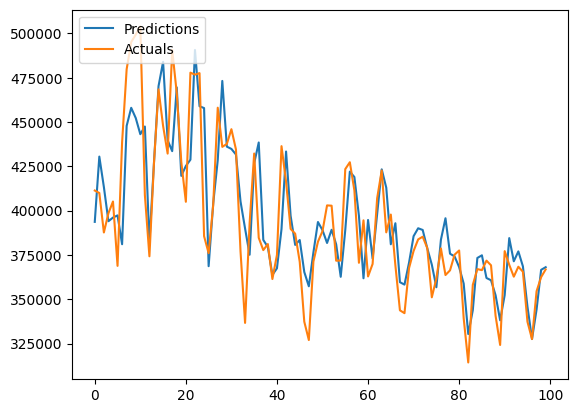

MAPE: 4.14%
RMSE: 20473.30
MAE : 15675.78


Predictions    Actuals
0    393662.18750  411339.27
1    430487.28125  409963.40
2    413323.71875  387672.63
3    394031.68750  398542.65
4    396078.43750  405159.36
..            ...        ...
353  374680.78125  360393.59
354  380780.18750  369325.03
355  380436.18750  371819.56
356  373103.06250  399427.25
357  377994.21875  408178.89

[358 rows x 2 columns]

In [97]:
predictions_plot(model11, X_test11, y_test11, 0, 100)

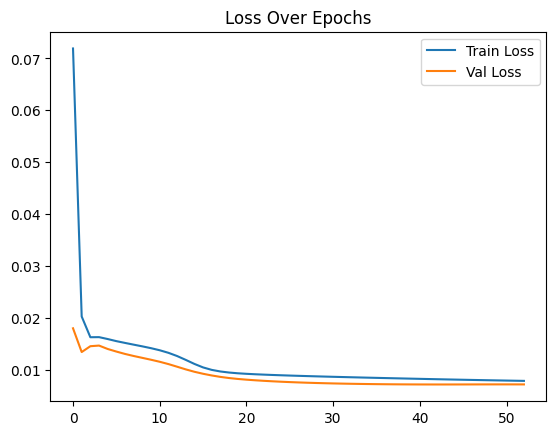

In [98]:
plt.plot(history11.history['loss'], label='Train Loss')
plt.plot(history11.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

## Introduce Other Weather Features ##

## Model 12 - Precipitation ##

In [18]:
tempPrecipDemandDF = test_df[['sum_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h', 'precipitation', 'temp_range']].copy()

In [100]:
preprocessor = TimeSeriesPreprocessorTVT(tempPrecipDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data12 = preprocessor.get_model_inputs(target_col = 'sum_30_min_demand')

X_train12, y_train12 = data12['train']
X_val12, y_val12 = data12['val']
X_test12, y_test12 = data12['test']

i = X_train12.shape[1]
j = X_train12.shape[2]

In [101]:
# set seed
reset_seed()

model12 = Sequential()
model12.add(InputLayer((i, j)))
model12.add(LSTM(64))
model12.add(Dense(8, 'tanh'))
model12.add(Dense(1, 'linear'))

model12.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_11 (LSTM)                  │ (None, 64)             │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,217 (75.07 KB)

 Trainable params: 19,217 (75.07 KB)

 Non-trainable params: 0 (0.00 B)

In [102]:
cp12 = ModelCheckpoint('model12.keras', save_best_only=True)
model12.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history12 = model12.fit(X_train12, y_train12, validation_data=(X_val12, y_val12), epochs=100, callbacks=[cp12, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.1577 - root_mean_squared_error: 0.3831 - val_loss: 0.0188 - val_root_mean_squared_error: 0.1372
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0211 - root_mean_squared_error: 0.1450 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1124
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0167 - root_mean_squared_error: 0.1291 - val_loss: 0.0136 - val_root_mean_squared_error: 0.1164
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0164 - root_mean_squared_error: 0.1282 - val_loss: 0.0143 - val_root_mean_squared_error: 0.1195
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0162 - root_mean_squared_error: 0.1273 - val_loss: 0.0135 - val_root_mean_squared_error: 0.1161
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0155 - root_mean_squared_error: 0.1245 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1126
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


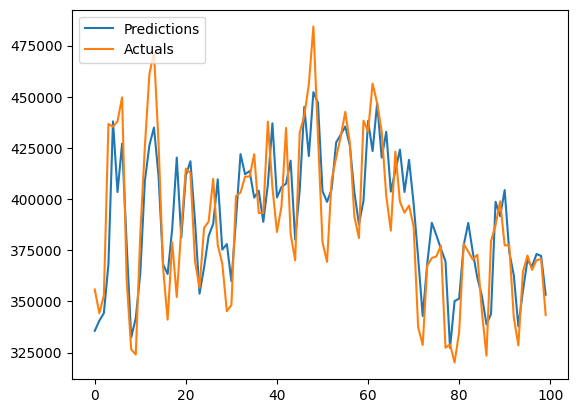

MAPE: 3.41%
RMSE: 17588.42
MAE : 13092.28


Predictions    Actuals
0    335596.56250  355814.96
1    340537.21875  344216.79
2    344280.81250  352812.68
3    368065.71875  436716.40
4    437967.71875  435360.14
..            ...        ...
719  386566.84375  353967.95
720  399005.78125  385900.00
721  407422.56250  411636.83
722  389788.15625  379656.38
723  356309.53125  342930.54

[724 rows x 2 columns]

In [103]:
model12 = load_model('model12.keras')

predictions_plot(model12, X_train12, y_train12, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


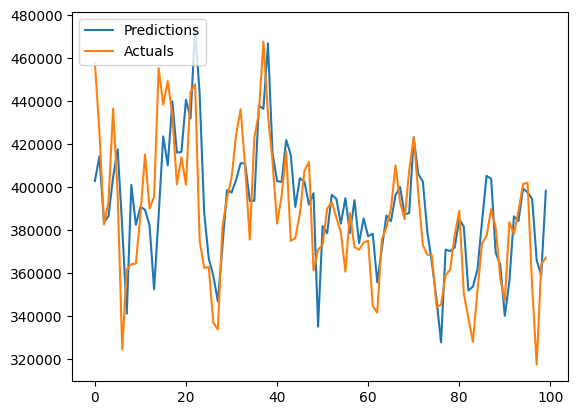

MAPE: 3.49%
RMSE: 17652.99
MAE : 13273.13


Predictions    Actuals
0    402892.40625  457780.70
1    414385.15625  425439.99
2    383602.71875  382741.80
3    386654.75000  393359.12
4    404676.65625  436628.85
..            ...        ...
353  387957.21875  405457.46
354  412405.93750  421027.63
355  416226.90625  407376.71
356  393952.03125  402263.51
357  383943.37500  405023.08

[358 rows x 2 columns]

In [104]:
predictions_plot(model12, X_val12, y_val12, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


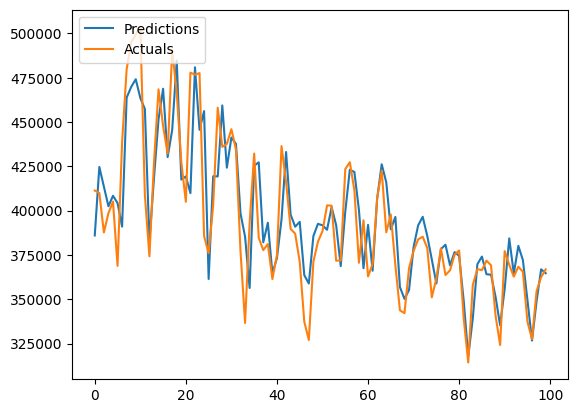

MAPE: 3.93%
RMSE: 19580.95
MAE : 14810.21


Predictions    Actuals
0    385996.78125  411339.27
1    424624.37500  409963.40
2    413584.21875  387672.63
3    402478.93750  398542.65
4    408387.15625  405159.36
..            ...        ...
353  391287.75000  360393.59
354  403710.65625  369325.03
355  405071.75000  371819.56
356  401366.28125  399427.25
357  378542.81250  408178.89

[358 rows x 2 columns]

In [105]:
predictions_plot(model12, X_test12, y_test12, 0, 100)

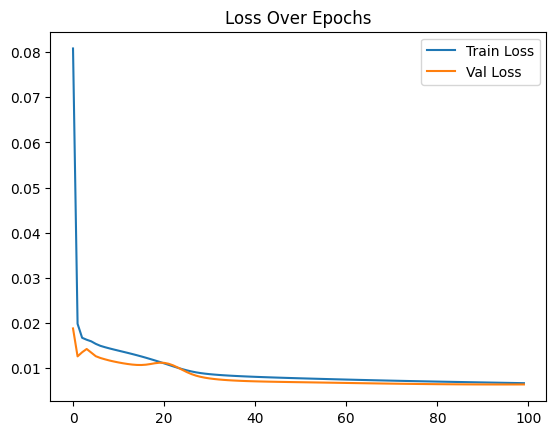

In [106]:
plt.plot(history12.history['loss'], label='Train Loss')
plt.plot(history12.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

## Model 13 - Sunlight ##

In [19]:
tempSunDemandDF = test_df[['sum_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h', 'sunlight', 'temp_range']].copy()

In [108]:
preprocessor = TimeSeriesPreprocessorTVT(tempSunDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data13 = preprocessor.get_model_inputs(target_col = 'sum_30_min_demand')

X_train13, y_train13 = data13['train']
X_val13, y_val13 = data13['val']
X_test13, y_test13 = data13['test']

i = X_train13.shape[1]
j = X_train13.shape[2]

In [109]:
# set seed
reset_seed()

model13 = Sequential()
model13.add(InputLayer((i, j)))
model13.add(LSTM(64))
model13.add(Dense(8, 'tanh'))
model13.add(Dense(1, 'linear'))

model13.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 64)             │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,217 (75.07 KB)

 Trainable params: 19,217 (75.07 KB)

 Non-trainable params: 0 (0.00 B)

In [110]:
cp13 = ModelCheckpoint('model13.keras', save_best_only=True)
model13.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history13 = model13.fit(X_train13, y_train13, validation_data=(X_val13, y_val13), epochs=100, callbacks=[cp13, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.1399 - root_mean_squared_error: 0.3618 - val_loss: 0.0137 - val_root_mean_squared_error: 0.1172
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0207 - root_mean_squared_error: 0.1437 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1177
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0174 - root_mean_squared_error: 0.1317 - val_loss: 0.0148 - val_root_mean_squared_error: 0.1217
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0162 - root_mean_squared_error: 0.1272 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1142
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0151 - root_mean_squared_error: 0.1229 - val_loss: 0.0122 - val_root_mean_squared_error: 0.1106
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0146 - root_mean_squared_error: 0.1208 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1098
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - los

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


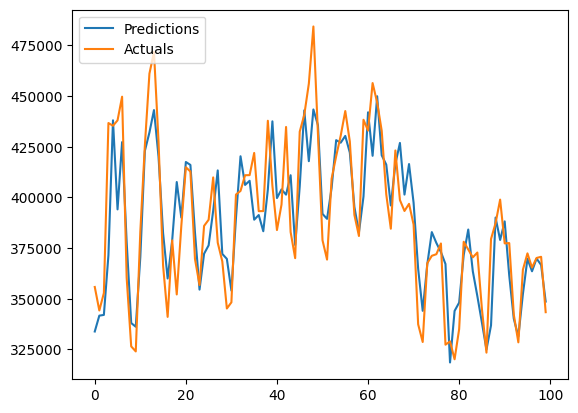

MAPE: 3.44%
RMSE: 18049.02
MAE : 13220.29


Predictions    Actuals
0    333840.12500  355814.96
1    341662.84375  344216.79
2    342029.84375  352812.68
3    371504.75000  436716.40
4    438051.81250  435360.14
..            ...        ...
719  382037.81250  353967.95
720  391870.34375  385900.00
721  396473.87500  411636.83
722  391282.81250  379656.38
723  354437.40625  342930.54

[724 rows x 2 columns]

In [111]:
model13 = load_model('model13.keras')
predictions_plot(model13, X_train13, y_train13, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


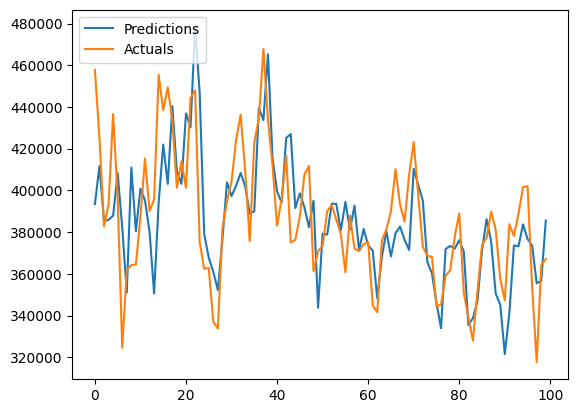

MAPE: 3.74%
RMSE: 18729.73
MAE : 14278.77


Predictions    Actuals
0    393418.43750  457780.70
1    411650.12500  425439.99
2    385291.09375  382741.80
3    385846.46875  393359.12
4    387927.21875  436628.85
..            ...        ...
353  394601.06250  405457.46
354  405345.15625  421027.63
355  402021.71875  407376.71
356  384900.84375  402263.51
357  378237.87500  405023.08

[358 rows x 2 columns]

In [112]:
predictions_plot(model13, X_val13, y_val13, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


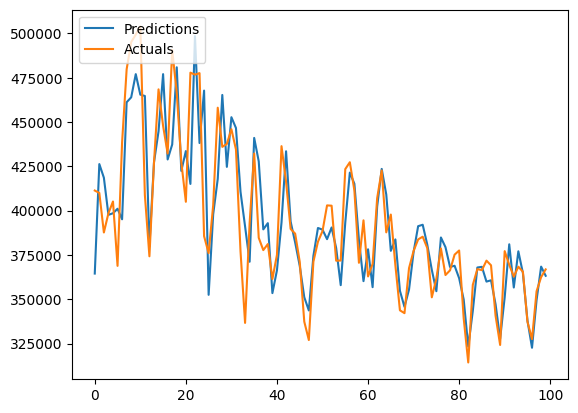

MAPE: 3.93%
RMSE: 19670.14
MAE : 14962.30


Predictions    Actuals
0    364499.50000  411339.27
1    426274.62500  409963.40
2    418580.25000  387672.63
3    397629.00000  398542.65
4    398529.00000  405159.36
..            ...        ...
353  387233.40625  360393.59
354  387543.18750  369325.03
355  385013.21875  371819.56
356  377353.37500  399427.25
357  374829.87500  408178.89

[358 rows x 2 columns]

In [113]:
predictions_plot(model13, X_test13, y_test13, 0, 100)

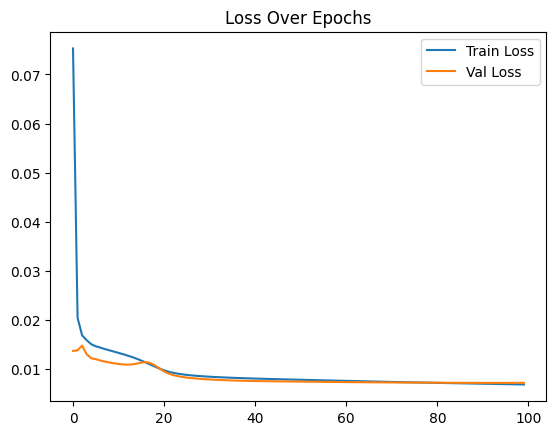

In [114]:
plt.plot(history13.history['loss'], label='Train Loss')
plt.plot(history13.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

## Model 14 - Precipitation and Sunlight ##

In [20]:
tempPreSunDemandDF = test_df[['sum_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h', 'precipitation', 'sunlight', 'temp_range']].copy()


In [116]:
preprocessor = TimeSeriesPreprocessorTVT(tempPreSunDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data14 = preprocessor.get_model_inputs(target_col = 'sum_30_min_demand')

X_train14, y_train14 = data14['train']
X_val14, y_val14 = data14['val']
X_test14, y_test14 = data14['test']

i = X_train14.shape[1]
j = X_train14.shape[2]

In [117]:
# set seed
reset_seed()

model14 = Sequential()
model14.add(InputLayer((i, j)))
model14.add(LSTM(64))
model14.add(Dense(8, 'tanh'))
model14.add(Dense(1, 'linear'))

model14.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_13 (LSTM)                  │ (None, 64)             │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,473 (76.07 KB)

 Trainable params: 19,473 (76.07 KB)

 Non-trainable params: 0 (0.00 B)

In [118]:
cp14 = ModelCheckpoint('model14.keras', save_best_only=True)
model14.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history14 = model14.fit(X_train14, y_train14, validation_data=(X_val14, y_val14), epochs=100, callbacks=[cp14, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.1565 - root_mean_squared_error: 0.3817 - val_loss: 0.0183 - val_root_mean_squared_error: 0.1353
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0216 - root_mean_squared_error: 0.1469 - val_loss: 0.0122 - val_root_mean_squared_error: 0.1105
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0164 - root_mean_squared_error: 0.1279 - val_loss: 0.0134 - val_root_mean_squared_error: 0.1159
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0163 - root_mean_squared_error: 0.1276 - val_loss: 0.0140 - val_root_mean_squared_error: 0.1182
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0158 - root_mean_squared_error: 0.1256 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1137
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0150 - root_mean_squared_error: 0.1226 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1110
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


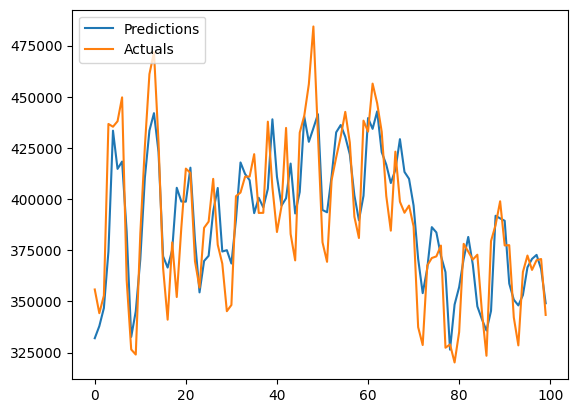

MAPE: 3.80%
RMSE: 19281.34
MAE : 14570.04


Predictions    Actuals
0    331985.09375  355814.96
1    337905.06250  344216.79
2    346721.06250  352812.68
3    374352.31250  436716.40
4    433426.37500  435360.14
..            ...        ...
719  373003.09375  353967.95
720  400764.25000  385900.00
721  395265.21875  411636.83
722  384085.78125  379656.38
723  359997.81250  342930.54

[724 rows x 2 columns]

In [119]:
model14 = load_model('model14.keras')

predictions_plot(model14, X_train14, y_train14, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


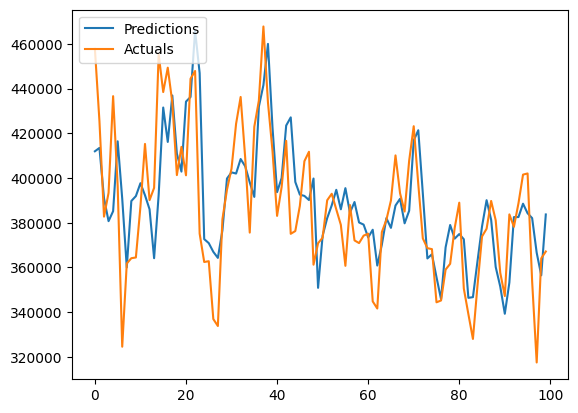

MAPE: 3.74%
RMSE: 18472.86
MAE : 14128.31


Predictions    Actuals
0    411970.71875  457780.70
1    413475.00000  425439.99
2    390959.96875  382741.80
3    380718.65625  393359.12
4    385169.62500  436628.85
..            ...        ...
353  397105.50000  405457.46
354  411267.62500  421027.63
355  411181.00000  407376.71
356  390931.84375  402263.51
357  385684.31250  405023.08

[358 rows x 2 columns]

In [120]:
predictions_plot(model14, X_val14, y_val14, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


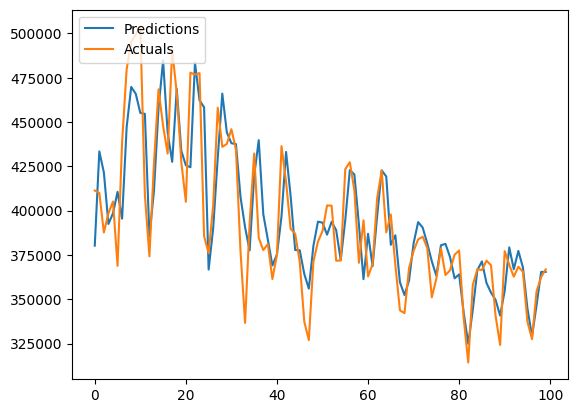

MAPE: 4.17%
RMSE: 20497.58
MAE : 15731.75


Predictions    Actuals
0    380243.03125  411339.27
1    433399.78125  409963.40
2    421515.87500  387672.63
3    392476.75000  398542.65
4    398483.46875  405159.36
..            ...        ...
353  383494.68750  360393.59
354  393653.56250  369325.03
355  392978.68750  371819.56
356  383501.37500  399427.25
357  384628.18750  408178.89

[358 rows x 2 columns]

In [121]:
predictions_plot(model14, X_test14, y_test14, 0, 100)

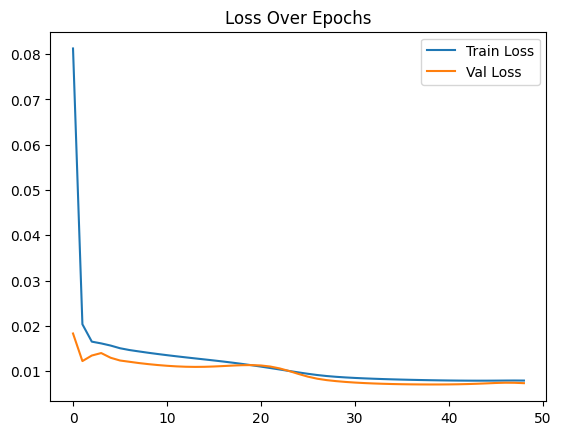

In [122]:
plt.plot(history14.history['loss'], label='Train Loss')
plt.plot(history14.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

## Seasonality ##

## Seasons ##

In [21]:
seasonsDemandDF = test_df[['is_winter', 'is_spring', 'is_summer', 'is_autumn','sum_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h', 'temp_range']].copy()

In [124]:
preprocessor = TimeSeriesPreprocessorTVT(seasonsDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data15 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

X_train15, y_train15 = data15['train']
X_val15, y_val15 = data15['val']
X_test15, y_test15 = data15['test']

i = X_train15.shape[1]
j = X_train15.shape[2]

In [125]:
# set seed
reset_seed()

model15 = Sequential()
model15.add(InputLayer((i, j)))
model15.add(LSTM(64))
model15.add(Dense(8, 'tanh'))
model15.add(Dense(1, 'linear'))

model15.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 64)             │        19,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,985 (78.07 KB)

 Trainable params: 19,985 (78.07 KB)

 Non-trainable params: 0 (0.00 B)

In [126]:
cp15 = ModelCheckpoint('model15.keras', save_best_only=True)
model15.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history15 = model15.fit(X_train15, y_train15, validation_data=(X_val15, y_val15), epochs=100, callbacks=[cp15, es2])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0774 - root_mean_squared_error: 0.2702 - val_loss: 0.0187 - val_root_mean_squared_error: 0.1366
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0200 - root_mean_squared_error: 0.1412 - val_loss: 0.0136 - val_root_mean_squared_error: 0.1167
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0170 - root_mean_squared_error: 0.1305 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1110
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0161 - root_mean_squared_error: 0.1268 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1101
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0156 - root_mean_squared_error: 0.1250 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1090
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0152 - root_mean_squared_error: 0.1234 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1087
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


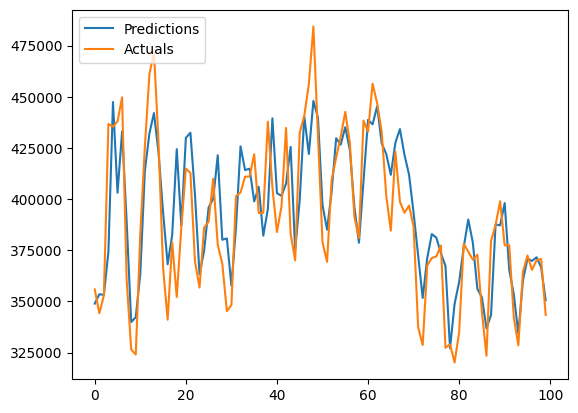

MAPE: 3.38%
RMSE: 17898.14
MAE : 12975.56


Predictions    Actuals
0    348894.34375  355814.96
1    353490.93750  344216.79
2    353150.68750  352812.68
3    374346.59375  436716.40
4    447446.46875  435360.14
..            ...        ...
719  377600.71875  353967.95
720  399843.56250  385900.00
721  399848.25000  411636.83
722  393042.03125  379656.38
723  344288.37500  342930.54

[724 rows x 2 columns]

In [127]:
model15 = load_model('model15.keras')

predictions_plot(model15, X_train15, y_train15, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


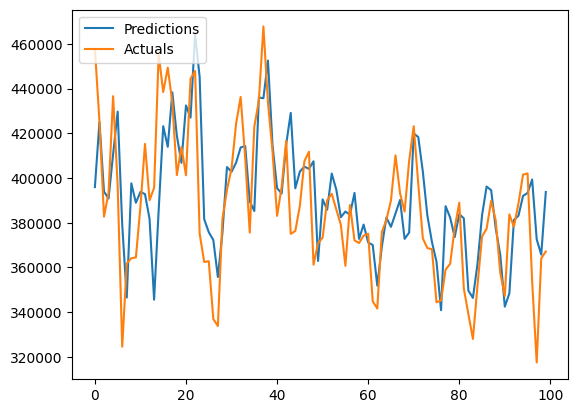

MAPE: 3.54%
RMSE: 18109.50
MAE : 13440.64


Predictions    Actuals
0    395948.71875  457780.70
1    425016.56250  425439.99
2    393945.37500  382741.80
3    390842.37500  393359.12
4    410690.50000  436628.85
..            ...        ...
353  388820.90625  405457.46
354  409281.06250  421027.63
355  403064.87500  407376.71
356  371048.46875  402263.51
357  363668.68750  405023.08

[358 rows x 2 columns]

In [128]:
predictions_plot(model15, X_val15, y_val15, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


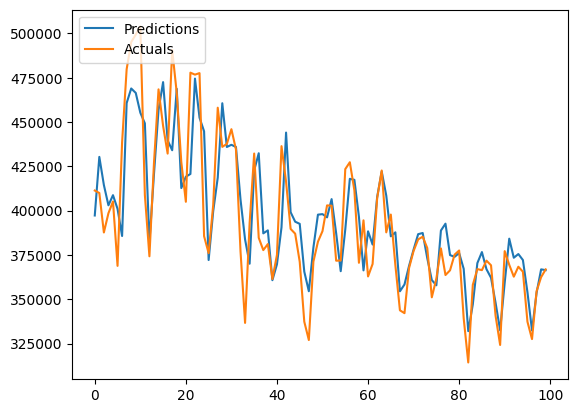

MAPE: 3.70%
RMSE: 18700.75
MAE : 13984.39


Predictions    Actuals
0    397255.18750  411339.27
1    430318.18750  409963.40
2    414462.84375  387672.63
3    403017.68750  398542.65
4    408723.65625  405159.36
..            ...        ...
353  382291.65625  360393.59
354  384659.96875  369325.03
355  389146.43750  371819.56
356  377953.43750  399427.25
357  378028.53125  408178.89

[358 rows x 2 columns]

In [129]:
predictions_plot(model15, X_test15, y_test15, 0, 100)

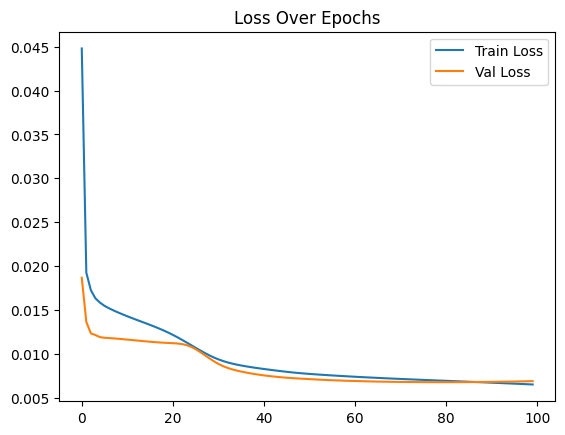

In [130]:
plt.plot(history15.history['loss'], label='Train Loss')
plt.plot(history15.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

## Weekday/Weekend ##

In [22]:
weekendDemandDF = test_df[['is_weekday', 'is_weekend', 'sum_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h', 'temp_range']].copy()

In [132]:
preprocessor = TimeSeriesPreprocessorTVT(weekendDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data16 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

X_train16, y_train16 = data16['train']
X_val16, y_val16 = data16['val']
X_test16, y_test16 = data16['test']

i = X_train16.shape[1]
j = X_train16.shape[2]

In [133]:
# set seed
reset_seed()

model16 = Sequential()
model16.add(InputLayer((7, 9)))
model16.add(LSTM(64))
model16.add(Dense(8, 'tanh'))
model16.add(Dense(1, 'linear'))

model16.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_15 (LSTM)                  │ (None, 64)             │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,473 (76.07 KB)

 Trainable params: 19,473 (76.07 KB)

 Non-trainable params: 0 (0.00 B)

In [134]:
cp16 = ModelCheckpoint('model16.keras', save_best_only=True)
model16.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history16 = model16.fit(X_train16, y_train16, validation_data=(X_val16, y_val16), epochs=100, callbacks=[cp16, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.1390 - root_mean_squared_error: 0.3578 - val_loss: 0.0150 - val_root_mean_squared_error: 0.1227
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0173 - root_mean_squared_error: 0.1313 - val_loss: 0.0101 - val_root_mean_squared_error: 0.1007
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0130 - root_mean_squared_error: 0.1140 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1056
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0123 - root_mean_squared_error: 0.1107 - val_loss: 0.0099 - val_root_mean_squared_error: 0.0997
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0108 - root_mean_squared_error: 0.1039 - val_loss: 0.0090 - val_root_mean_squared_error: 0.0949
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0101 - root_mean_squared_error: 0.1005 - val_loss: 0.0088 - val_root_mean_squared_error: 0.0937
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


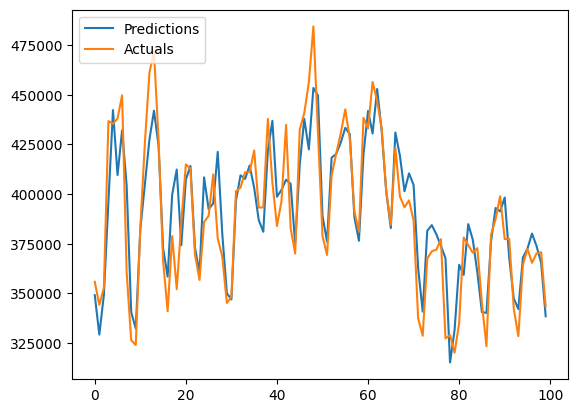

MAPE: 2.95%
RMSE: 16000.32
MAE : 11313.88


Predictions    Actuals
0    349086.31250  355814.96
1    329236.37500  344216.79
2    349251.87500  352812.68
3    396299.21875  436716.40
4    442268.25000  435360.14
..            ...        ...
719  352918.21875  353967.95
720  382363.00000  385900.00
721  386762.68750  411636.83
722  372619.03125  379656.38
723  350276.56250  342930.54

[724 rows x 2 columns]

In [135]:
model16 = load_model('model16.keras')

predictions_plot(model16, X_train16, y_train16, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


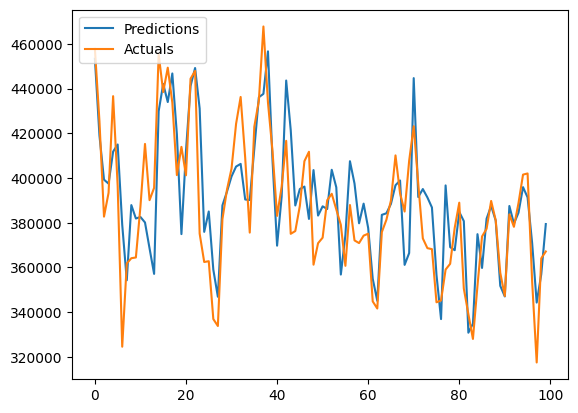

MAPE: 3.14%
RMSE: 16121.04
MAE : 11918.71


Predictions    Actuals
0    453332.75000  457780.70
1    419031.25000  425439.99
2    399274.40625  382741.80
3    397494.18750  393359.12
4    411819.84375  436628.85
..            ...        ...
353  366455.46875  405457.46
354  383240.18750  421027.63
355  374920.00000  407376.71
356  373444.65625  402263.51
357  416886.28125  405023.08

[358 rows x 2 columns]

In [136]:
predictions_plot(model16, X_val16, y_val16, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


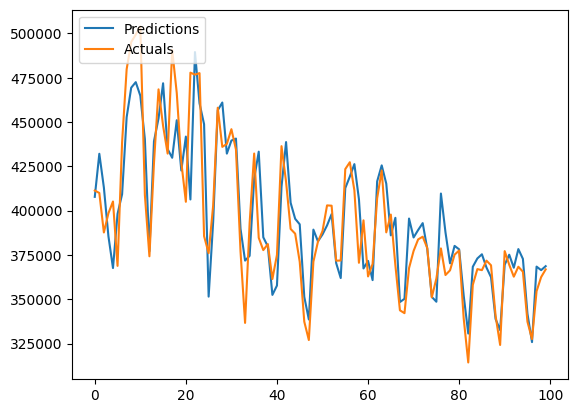

MAPE: 3.42%
RMSE: 17526.88
MAE : 12999.84


Predictions    Actuals
0    407770.87500  411339.27
1    432078.28125  409963.40
2    413031.43750  387672.63
3    385529.62500  398542.65
4    367622.18750  405159.36
..            ...        ...
353  349956.34375  360393.59
354  335364.43750  369325.03
355  365043.65625  371819.56
356  406984.25000  399427.25
357  401008.46875  408178.89

[358 rows x 2 columns]

In [137]:
predictions_plot(model16, X_test16, y_test16, 0, 100)

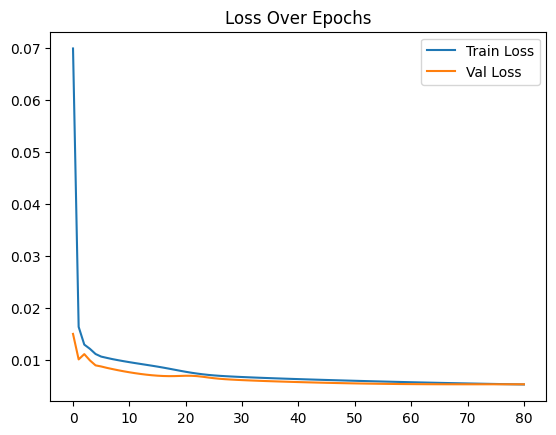

In [138]:
plt.plot(history16.history['loss'], label='Train Loss')
plt.plot(history16.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

## Day Of Week ##

In [23]:
dayDemandDF = test_df[['is_sunday','is_monday', 'is_tuesday', 'is_wednesday', 'is_thursday', 'is_friday','is_saturday', 'sum_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h','temp_range']].copy()

In [140]:
preprocessor = TimeSeriesPreprocessorTVT(dayDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data17 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

X_train17, y_train17 = data17['train']
X_val17, y_val17 = data17['val']
X_test17, y_test17 = data17['test']

i = X_train17.shape[1]
j = X_train17.shape[2]

In [141]:
# set seed
reset_seed()

model17 = Sequential()
model17.add(InputLayer((i, j)))
model17.add(LSTM(64))
model17.add(Dense(8, 'tanh'))
model17.add(Dense(1, 'linear'))

model17.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ (None, 64)             │        20,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,753 (81.07 KB)

 Trainable params: 20,753 (81.07 KB)

 Non-trainable params: 0 (0.00 B)

In [142]:
cp17 = ModelCheckpoint('model17.keras', save_best_only=True)
model17.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history17 = model17.fit(X_train17, y_train17, validation_data=(X_val17, y_val17), epochs=100, callbacks=[cp17, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0553 - root_mean_squared_error: 0.2312 - val_loss: 0.0192 - val_root_mean_squared_error: 0.1386
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0156 - root_mean_squared_error: 0.1250 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0932
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0096 - root_mean_squared_error: 0.0978 - val_loss: 0.0085 - val_root_mean_squared_error: 0.0920
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0090 - root_mean_squared_error: 0.0946 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0878
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0085 - root_mean_squared_error: 0.0921 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0865
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0082 - root_mean_squared_error: 0.0906 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0856
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


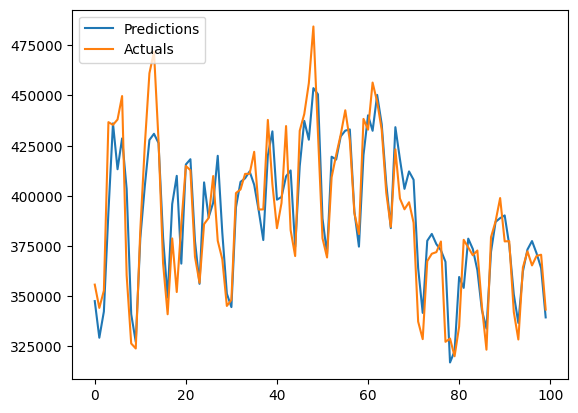

MAPE: 2.66%
RMSE: 14856.82
MAE : 10259.21


Predictions    Actuals
0    347601.50000  355814.96
1    329372.37500  344216.79
2    342406.65625  352812.68
3    392018.46875  436716.40
4    436111.18750  435360.14
..            ...        ...
719  344286.28125  353967.95
720  381713.53125  385900.00
721  384952.43750  411636.83
722  376586.46875  379656.38
723  345535.59375  342930.54

[724 rows x 2 columns]

In [143]:
model17 = load_model('model17.keras')

predictions_plot(model17, X_train17, y_train17, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


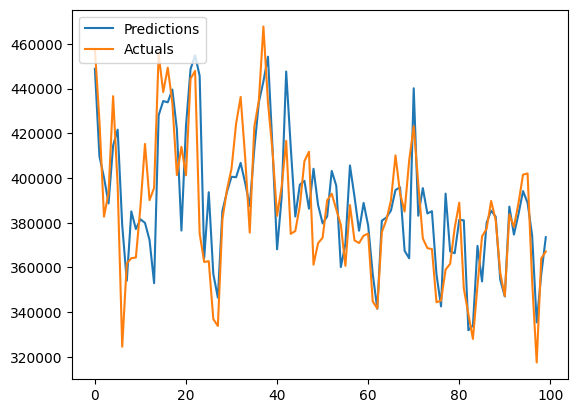

MAPE: 2.87%
RMSE: 15319.57
MAE : 10927.41


Predictions    Actuals
0    448870.06250  457780.70
1    409664.53125  425439.99
2    400217.96875  382741.80
3    388662.81250  393359.12
4    414550.31250  436628.85
..            ...        ...
353  361906.53125  405457.46
354  381448.46875  421027.63
355  376827.43750  407376.71
356  366088.21875  402263.51
357  414924.21875  405023.08

[358 rows x 2 columns]

In [144]:
predictions_plot(model17, X_val17, y_val17, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


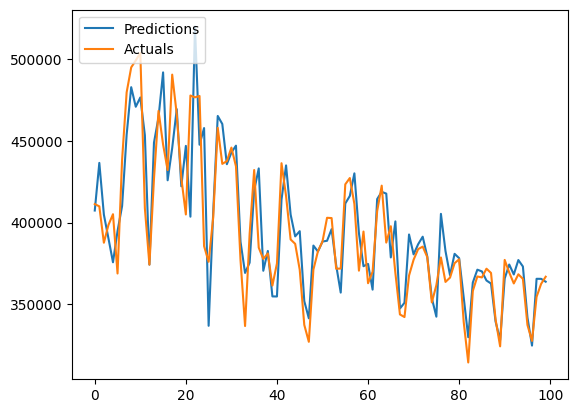

MAPE: 3.15%
RMSE: 16661.19
MAE : 12026.87


Predictions    Actuals
0    407403.40625  411339.27
1    436579.93750  409963.40
2    404898.12500  387672.63
3    390424.09375  398542.65
4    375715.06250  405159.36
..            ...        ...
353  349014.93750  360393.59
354  336823.40625  369325.03
355  354791.06250  371819.56
356  405874.59375  399427.25
357  389257.59375  408178.89

[358 rows x 2 columns]

In [145]:
predictions_plot(model17, X_test17, y_test17, 0, 100)

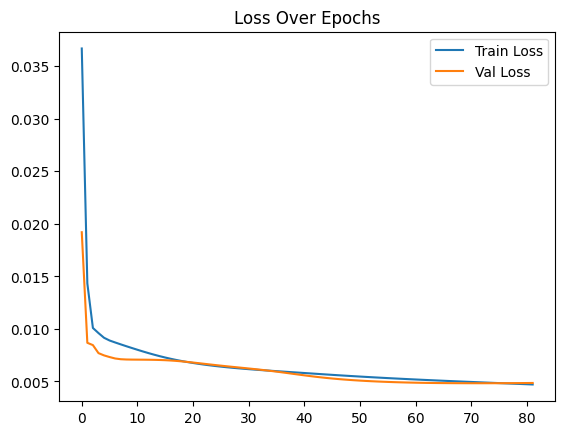

In [146]:
plt.plot(history17.history['loss'], label='Train Loss')
plt.plot(history17.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

## Month ##

In [24]:
monthDemandDF = test_df[['is_jan', 'is_feb', 'is_mar','is_apr', 'is_may', 'is_jun', 'is_jul', 'is_aug', 'is_sep', 'is_oct','is_nov', 'is_dec', 'sum_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h', 'temp_range']].copy()

In [148]:
preprocessor = TimeSeriesPreprocessorTVT(monthDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data18 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

X_train18, y_train18 = data18['train']
X_val18, y_val18 = data18['val']
X_test18, y_test18 = data18['test']

i = X_train18.shape[1]
j = X_train18.shape[2]

In [149]:
# set seed
reset_seed()

model18 = Sequential()
model18.add(InputLayer((i, j)))
model18.add(LSTM(64))
model18.add(Dense(8, 'tanh'))
model18.add(Dense(1, 'linear'))

model18.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_17 (LSTM)                  │ (None, 64)             │        21,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,033 (86.07 KB)

 Trainable params: 22,033 (86.07 KB)

 Non-trainable params: 0 (0.00 B)

In [150]:
cp18 = ModelCheckpoint('model18.keras', save_best_only=True)
model18.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history18 = model18.fit(X_train18, y_train18, validation_data=(X_val18, y_val18), epochs=100, callbacks=[cp18, es2])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0600 - root_mean_squared_error: 0.2411 - val_loss: 0.0188 - val_root_mean_squared_error: 0.1372
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0206 - root_mean_squared_error: 0.1436 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1097
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0157 - root_mean_squared_error: 0.1253 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1090
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0152 - root_mean_squared_error: 0.1233 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1072
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0147 - root_mean_squared_error: 0.1210 - val_loss: 0.0113 - val_root_mean_squared_error: 0.1065
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0143 - root_mean_squared_error: 0.1194 - val_loss: 0.0113 - val_root_mean_squared_error: 0.1061
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - los

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


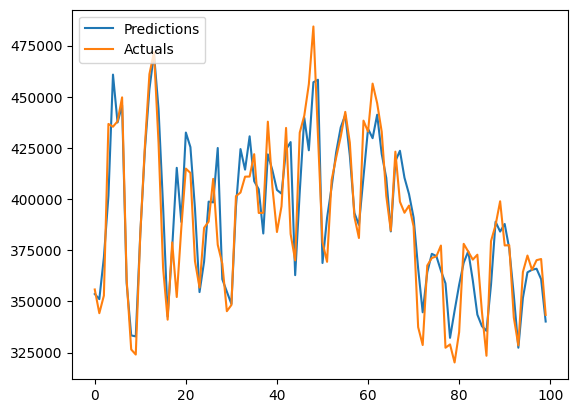

MAPE: 2.87%
RMSE: 15211.63
MAE : 11074.17


Predictions    Actuals
0    353594.34375  355814.96
1    351090.37500  344216.79
2    371473.28125  352812.68
3    401556.46875  436716.40
4    460830.87500  435360.14
..            ...        ...
719  371114.50000  353967.95
720  396505.81250  385900.00
721  403776.78125  411636.83
722  401174.71875  379656.38
723  351913.62500  342930.54

[724 rows x 2 columns]

In [151]:
model18 = load_model('model18.keras')

predictions_plot(model18, X_train18, y_train18, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


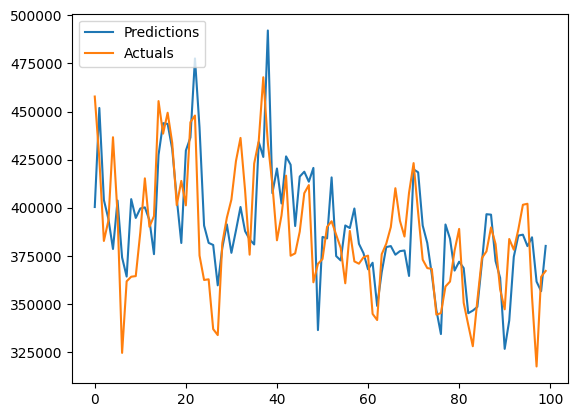

MAPE: 3.78%
RMSE: 19199.27
MAE : 14429.47


Predictions    Actuals
0    400364.21875  457780.70
1    451834.87500  425439.99
2    404033.78125  382741.80
3    394137.87500  393359.12
4    378555.37500  436628.85
..            ...        ...
353  381571.18750  405457.46
354  411013.31250  421027.63
355  414311.68750  407376.71
356  381838.65625  402263.51
357  362441.34375  405023.08

[358 rows x 2 columns]

In [152]:
predictions_plot(model18, X_val18, y_val18, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


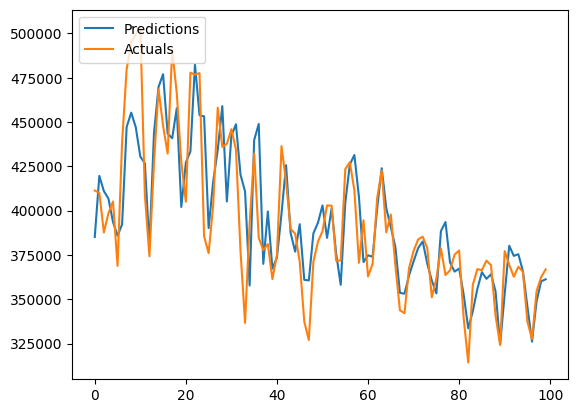

MAPE: 4.07%
RMSE: 20130.16
MAE : 15355.06


Predictions    Actuals
0    385163.81250  411339.27
1    419611.84375  409963.40
2    411023.53125  387672.63
3    406811.43750  398542.65
4    393599.90625  405159.36
..            ...        ...
353  376206.90625  360393.59
354  388147.50000  369325.03
355  388199.62500  371819.56
356  387796.75000  399427.25
357  385594.87500  408178.89

[358 rows x 2 columns]

In [153]:
predictions_plot(model18, X_test18, y_test18, 0, 100)

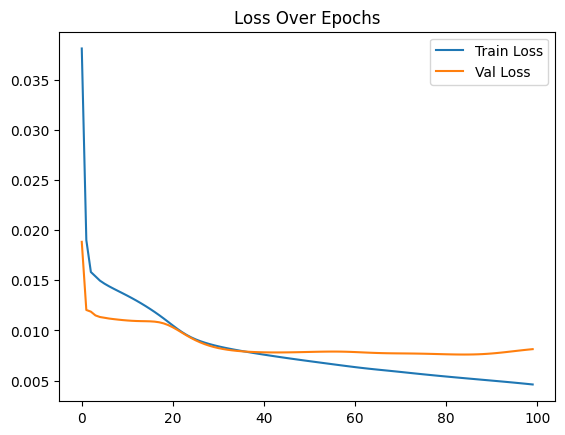

In [154]:
plt.plot(history18.history['loss'], label='Train Loss')
plt.plot(history18.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

## Seasons & Weekday/Weekend ##

In [25]:
seasonsWdWeDemandDF = test_df[['is_weekend','is_weekday','is_winter', 'is_spring', 'is_summer', 'is_autumn','sum_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h','temp_range']].copy()

In [156]:
preprocessor = TimeSeriesPreprocessorTVT(seasonsWdWeDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data19 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

X_train19, y_train19 = data19['train']
X_val19, y_val19 = data19['val']
X_test19, y_test19 = data19['test']

i = X_train19.shape[1]
j = X_train19.shape[2]

In [157]:
# set seed
reset_seed()

model19 = Sequential()
model19.add(InputLayer((i, j)))
model19.add(LSTM(64))
model19.add(Dense(8, 'tanh'))
model19.add(Dense(1, 'linear'))

model19.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ (None, 64)             │        19,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,497 (80.07 KB)

 Trainable params: 20,497 (80.07 KB)

 Non-trainable params: 0 (0.00 B)

In [158]:
cp19 = ModelCheckpoint('model19.keras', save_best_only=True)
model19.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history19 = model19.fit(X_train19, y_train19, validation_data=(X_val19, y_val19), epochs=100, callbacks=[cp19, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.1401 - root_mean_squared_error: 0.3608 - val_loss: 0.0141 - val_root_mean_squared_error: 0.1189
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0194 - root_mean_squared_error: 0.1392 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1112
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0155 - root_mean_squared_error: 0.1245 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1073
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0131 - root_mean_squared_error: 0.1145 - val_loss: 0.0091 - val_root_mean_squared_error: 0.0954
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0112 - root_mean_squared_error: 0.1057 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0901
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0102 - root_mean_squared_error: 0.1010 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0890
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


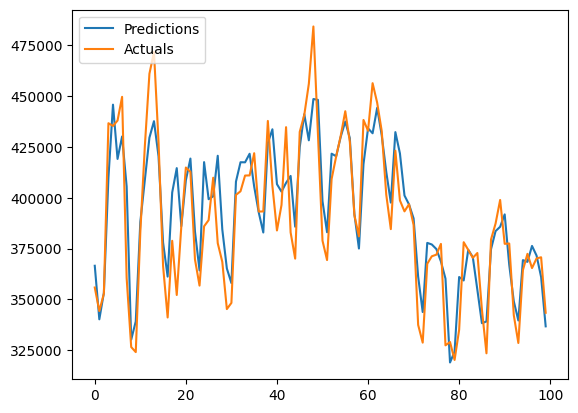

MAPE: 2.92%
RMSE: 16156.34
MAE : 11246.02


Predictions    Actuals
0    366521.09375  355814.96
1    340151.53125  344216.79
2    353213.84375  352812.68
3    409887.81250  436716.40
4    445855.12500  435360.14
..            ...        ...
719  358178.62500  353967.95
720  382898.00000  385900.00
721  386536.90625  411636.83
722  380212.31250  379656.38
723  357534.06250  342930.54

[724 rows x 2 columns]

In [159]:
model19 = load_model('model19.keras')

predictions_plot(model19, X_train19, y_train19, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


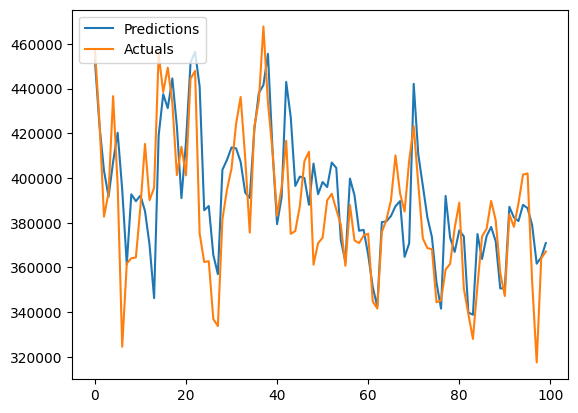

MAPE: 3.14%
RMSE: 16608.10
MAE : 11929.62


Predictions    Actuals
0    452679.56250  457780.70
1    423604.18750  425439.99
2    403277.56250  382741.80
3    391657.87500  393359.12
4    407239.56250  436628.85
..            ...        ...
353  372761.09375  405457.46
354  380558.50000  421027.63
355  372284.34375  407376.71
356  362206.75000  402263.51
357  408573.25000  405023.08

[358 rows x 2 columns]

In [160]:
predictions_plot(model19, X_val19, y_val19, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


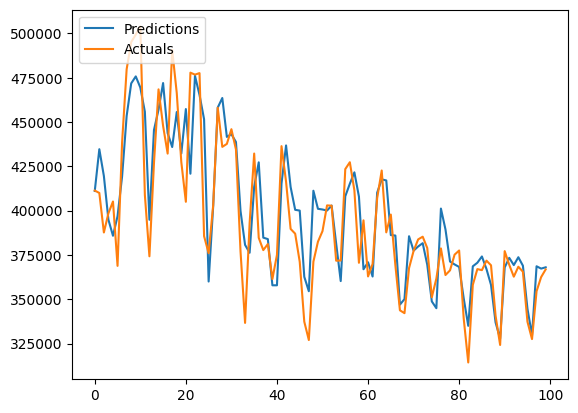

MAPE: 3.31%
RMSE: 17487.60
MAE : 12544.04


Predictions    Actuals
0    411096.43750  411339.27
1    434654.75000  409963.40
2    419536.06250  387672.63
3    394850.03125  398542.65
4    385824.28125  405159.36
..            ...        ...
353  357357.03125  360393.59
354  342993.34375  369325.03
355  356296.65625  371819.56
356  403657.93750  399427.25
357  403715.40625  408178.89

[358 rows x 2 columns]

In [161]:
predictions_plot(model19, X_test19, y_test19, 0, 100)

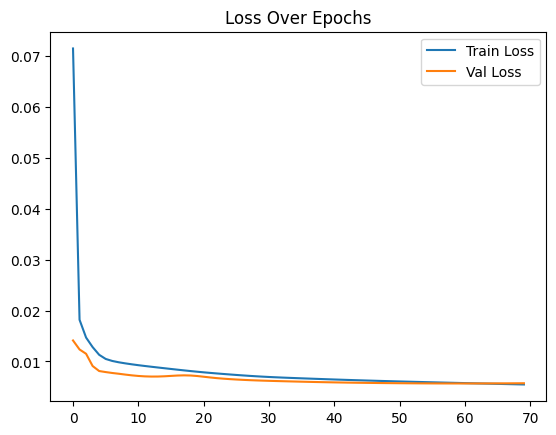

In [162]:
plt.plot(history19.history['loss'], label='Train Loss')
plt.plot(history19.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

## Switch to train/test only - compare Seasons & Seasons/Weekend ##

## Seasons & Weekday/Weekend - Train/Test ##

In [163]:
preprocessor = TimeSeriesPreprocessorTT(seasonsWdWeDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data20 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

X_train20, y_train20 = data20['train']
X_test20, y_test20 = data20['test']

i = X_train20.shape[1]
j = X_train20.shape[2]

In [164]:
# set seed
reset_seed()

model20 = Sequential()
model20.add(InputLayer((i, j)))
model20.add(LSTM(64))
model20.add(Dense(8, 'tanh'))
model20.add(Dense(1, 'linear'))

model20.summary()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_19 (LSTM)                  │ (None, 64)             │        19,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,497 (80.07 KB)

 Trainable params: 20,497 (80.07 KB)

 Non-trainable params: 0 (0.00 B)

In [165]:
cp20 = ModelCheckpoint('model20.keras', monitor='loss', save_best_only=True)
model20.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history20 = model20.fit(X_train20, y_train20, epochs=100, callbacks=[cp20])

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1158 - root_mean_squared_error: 0.3248
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0135 - root_mean_squared_error: 0.1163
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0112 - root_mean_squared_error: 0.1060
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0102 - root_mean_squared_error: 0.1008
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0095 - root_mean_squared_error: 0.0973
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0091 - root_mean_squared_error: 0.0951
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0088 - root_mean_squared_error: 0.0935
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0085 - root_mean_squared_error: 0.0923
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0083 - root_mean_squared_error: 0.0913
Epoch 10/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0082 - root_mean_squared_error: 0.0903

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


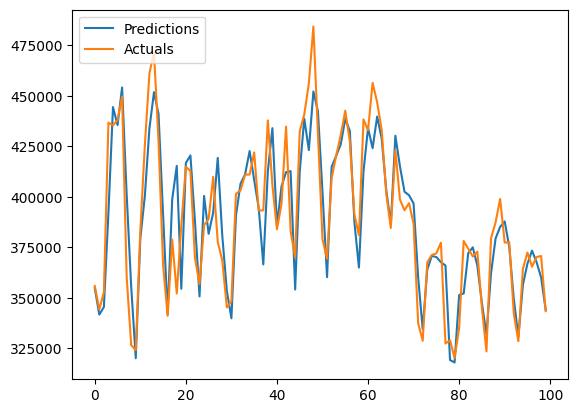

MAPE: 2.54%
RMSE: 13708.68
MAE : 9842.40


Predictions    Actuals
0     354798.09375  355814.96
1     341635.21875  344216.79
2     345403.15625  352812.68
3     392135.65625  436716.40
4     444440.75000  435360.14
...            ...        ...
1084  384169.71875  405457.46
1085  427791.37500  421027.63
1086  403933.50000  407376.71
1087  392693.81250  402263.51
1088  408054.53125  405023.08

[1089 rows x 2 columns]

In [166]:
model20 = load_model('model20.keras')

predictions_plot(model20, X_train20, y_train20, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


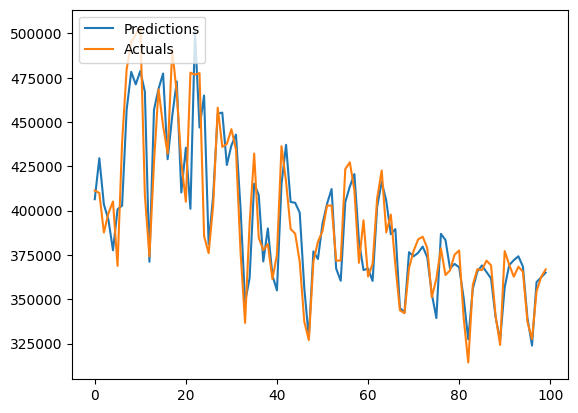

MAPE: 2.88%
RMSE: 15822.23
MAE : 11099.92


Predictions    Actuals
0    406464.56250  411339.27
1    429564.71875  409963.40
2    403502.90625  387672.63
3    394852.93750  398542.65
4    377638.96875  405159.36
..            ...        ...
353  360612.59375  360393.59
354  361172.09375  369325.03
355  387936.87500  371819.56
356  407141.09375  399427.25
357  391891.71875  408178.89

[358 rows x 2 columns]

In [167]:
predictions_plot(model20, X_test20, y_test20, 0, 100)

## Seasons Only - Train/Test ##

In [168]:
preprocessor = TimeSeriesPreprocessorTT(seasonsDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data21 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

X_train21, y_train21 = data21['train']
X_test21, y_test21 = data21['test']

i = X_train21.shape[1]
j = X_train21.shape[2]

In [169]:
# set seed
reset_seed()

model21 = Sequential()
model21.add(InputLayer((i, j)))
model21.add(LSTM(64))
model21.add(Dense(8, 'tanh'))
model21.add(Dense(1, 'linear'))

model21.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                  │ (None, 64)             │        19,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,985 (78.07 KB)

 Trainable params: 19,985 (78.07 KB)

 Non-trainable params: 0 (0.00 B)

In [170]:
cp21 = ModelCheckpoint('model21.keras', monitor='loss', save_best_only=True)
model21.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history21 = model21.fit(X_train21, y_train21, epochs=100, callbacks=[cp21])

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0670 - root_mean_squared_error: 0.2499
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0165 - root_mean_squared_error: 0.1286
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0147 - root_mean_squared_error: 0.1211
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0136 - root_mean_squared_error: 0.1167
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0130 - root_mean_squared_error: 0.1141
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0127 - root_mean_squared_error: 0.1126
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0124 - root_mean_squared_error: 0.1113
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0121 - root_mean_squared_error: 0.1100
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0119 - root_mean_squared_error: 0.1089
Epoch 10/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0116 - root_mean_squared_error: 0.1077

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


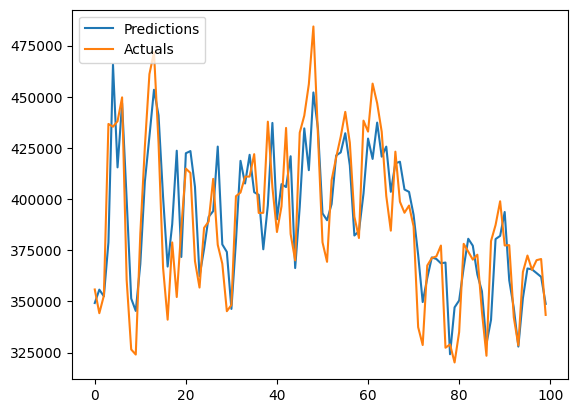

MAPE: 3.16%
RMSE: 16695.91
MAE : 12196.23


Predictions    Actuals
0     349193.31250  355814.96
1     355733.34375  344216.79
2     352489.71875  352812.68
3     378840.31250  436716.40
4     465797.40625  435360.14
...            ...        ...
1084  396190.25000  405457.46
1085  425267.59375  421027.63
1086  414284.56250  407376.71
1087  386662.53125  402263.51
1088  376600.71875  405023.08

[1089 rows x 2 columns]

In [171]:
model21 = load_model('model21.keras')
predictions_plot(model21, X_train21, y_train21, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


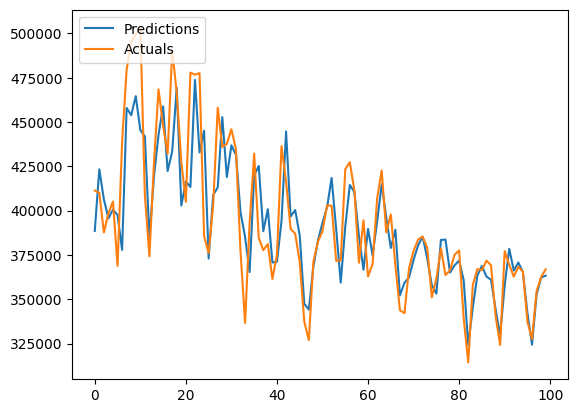

MAPE: 3.58%
RMSE: 18569.07
MAE : 13615.21


Predictions    Actuals
0    388563.43750  411339.27
1    423267.18750  409963.40
2    406409.25000  387672.63
3    395618.34375  398542.65
4    400581.56250  405159.36
..            ...        ...
353  385660.40625  360393.59
354  384007.34375  369325.03
355  389818.00000  371819.56
356  372605.75000  399427.25
357  376602.46875  408178.89

[358 rows x 2 columns]

In [172]:
predictions_plot(model21, X_test21, y_test21, 0, 100)

## Weekend/Weekday Only - Train/Test ##

In [173]:
preprocessor = TimeSeriesPreprocessorTT(weekendDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data22 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

X_train22, y_train22 = data22['train']
X_test22, y_test22 = data22['test']

i = X_train22.shape[1]
j = X_train22.shape[2]

In [174]:
# set seed
reset_seed()

model22 = Sequential()
model22.add(InputLayer((i, j)))
model22.add(LSTM(64))
model22.add(Dense(8, 'tanh'))
model22.add(Dense(1, 'linear'))

model22.summary()

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_21 (LSTM)                  │ (None, 64)             │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,473 (76.07 KB)

 Trainable params: 19,473 (76.07 KB)

 Non-trainable params: 0 (0.00 B)

In [175]:
cp22 = ModelCheckpoint('model22.keras', monitor='loss', save_best_only=True)
model22.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history22 = model22.fit(X_train22, y_train22, epochs=100, callbacks=[cp22])

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1086 - root_mean_squared_error: 0.3142
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0126 - root_mean_squared_error: 0.1121
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0108 - root_mean_squared_error: 0.1038
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0102 - root_mean_squared_error: 0.1009
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0099 - root_mean_squared_error: 0.0993
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0096 - root_mean_squared_error: 0.0980
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0093 - root_mean_squared_error: 0.0966
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0091 - root_mean_squared_error: 0.0953
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0088 - root_mean_squared_error: 0.0940
Epoch 10/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0086 - root_mean_squared_error: 0.0927

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


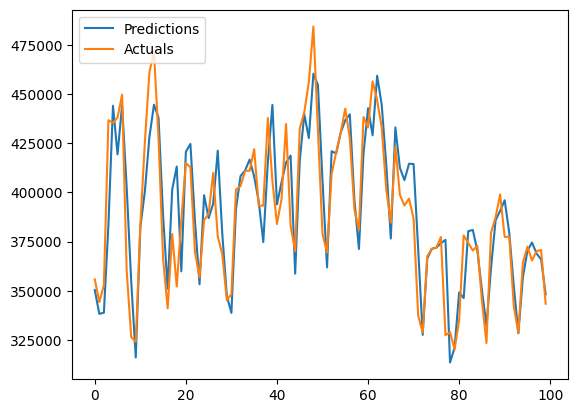

MAPE: 2.70%
RMSE: 14423.87
MAE : 10385.48


Predictions    Actuals
0     350368.25000  355814.96
1     338233.43750  344216.79
2     338819.06250  352812.68
3     383646.56250  436716.40
4     444063.21875  435360.14
...            ...        ...
1084  367079.84375  405457.46
1085  405129.21875  421027.63
1086  386454.56250  407376.71
1087  378794.62500  402263.51
1088  405860.87500  405023.08

[1089 rows x 2 columns]

In [176]:
model22 = load_model('model22.keras')

predictions_plot(model22, X_train22, y_train22, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


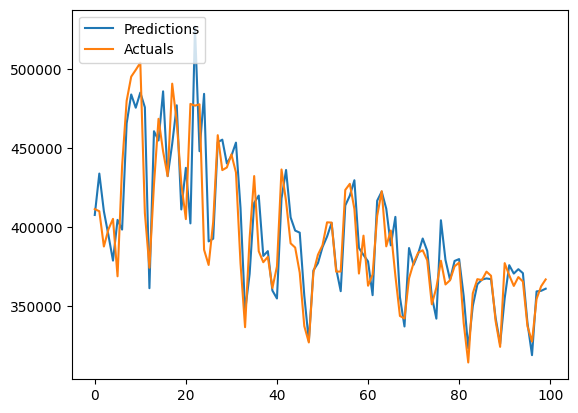

MAPE: 3.02%
RMSE: 16504.69
MAE : 11578.33


Predictions    Actuals
0    407616.15625  411339.27
1    433790.96875  409963.40
2    409966.56250  387672.63
3    394837.96875  398542.65
4    378772.09375  405159.36
..            ...        ...
353  351656.25000  360393.59
354  355206.81250  369325.03
355  373650.40625  371819.56
356  403983.84375  399427.25
357  386811.59375  408178.89

[358 rows x 2 columns]

In [177]:
predictions_plot(model22, X_test22, y_test22, 0, 100)

## Optuna Trials ##

In [ ]:
'''study = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(seed=42)  # Optional: set seed for reproducibility
)

study.optimize(objective, n_trials=100)'''

"study = optuna.create_study(\n    direction='minimize',\n    sampler=optuna.samplers.TPESampler(seed=42)  # Optional: set seed for reproducibility\n)\n\nstudy.optimize(objective, n_trials=100)"

In [ ]:
'''print("Best trial:")
trial = study.best_trial

print(f"  MAE: {trial.value:.2f}")
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")'''

'print("Best trial:")\ntrial = study.best_trial\n\nprint(f"  MAE: {trial.value:.2f}")\nprint("  Params:")\nfor key, value in trial.params.items():\n    print(f"    {key}: {value}")'

In [ ]:
'''study2 = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(seed=42)  # Optional: set seed for reproducibility
)

study2.optimize(objective2, n_trials=100)'''

"study2 = optuna.create_study(\n    direction='minimize',\n    sampler=optuna.samplers.TPESampler(seed=42)  # Optional: set seed for reproducibility\n)\n\nstudy2.optimize(objective2, n_trials=100)"

In [ ]:
'''print("Best trial:")
trial2 = study2.best_trial

print(f"  MAE: {trial2.value:.2f}")
print("  Params:")
for key, value in trial2.params.items():
    print(f"    {key}: {value}")'''

'print("Best trial:")\ntrial2 = study2.best_trial\n\nprint(f"  MAE: {trial2.value:.2f}")\nprint("  Params:")\nfor key, value in trial2.params.items():\n    print(f"    {key}: {value}")'

## Model 20 Re-Run (Post Optuna) ##

In [178]:
preprocessor = TimeSeriesPreprocessorTT(seasonsWdWeDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data23 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

X_train23, y_train23 = data23['train']
X_test23, y_test23 = data23['test']

i = X_train23.shape[1]
j = X_train23.shape[2]

In [179]:
# set seed
reset_seed()

model23 = Sequential()
model23.add(InputLayer((i, j)))
model23.add(LSTM(32, dropout=0.013))
model23.add(Dense(8, 'tanh'))
model23.add(Dense(1, 'linear'))

model23.summary()

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_22 (LSTM)                  │ (None, 32)             │         5,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,161 (24.07 KB)

 Trainable params: 6,161 (24.07 KB)

 Non-trainable params: 0 (0.00 B)

In [180]:
cp23 = ModelCheckpoint('model23.keras', monitor='loss', save_best_only=True)
model23.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0005, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history23 = model23.fit(X_train23, y_train23, epochs=100, batch_size=8, callbacks=[cp23])

Epoch 1/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0610 - root_mean_squared_error: 0.2359
Epoch 2/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0140 - root_mean_squared_error: 0.1182
Epoch 3/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0118 - root_mean_squared_error: 0.1086
Epoch 4/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0107 - root_mean_squared_error: 0.1032
Epoch 5/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0099 - root_mean_squared_error: 0.0993
Epoch 6/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0093 - root_mean_squared_error: 0.0961
Epoch 7/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0089 - root_mean_squared_error: 0.0943
Epoch 8/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0098 - root_mean_squared_error: 0.0986
Epoch 9/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0089 - root_mean_squared_error: 0.0940
Epoch 10/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0086 - root_mean_s

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


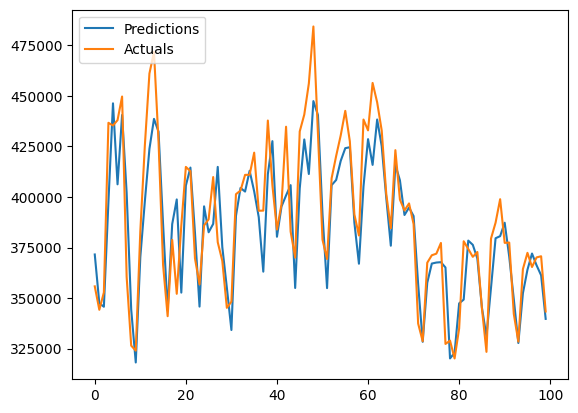

MAPE: 2.71%
RMSE: 14983.11
MAE : 10616.47


Predictions    Actuals
0     371582.90625  355814.96
1     347417.81250  344216.79
2     345732.53125  352812.68
3     397637.09375  436716.40
4     446347.31250  435360.14
...            ...        ...
1084  385363.25000  405457.46
1085  428000.78125  421027.63
1086  406796.75000  407376.71
1087  378214.71875  402263.51
1088  410574.87500  405023.08

[1089 rows x 2 columns]

In [181]:
model23 = load_model('model23.keras')

predictions_plot(model23, X_train23, y_train23, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


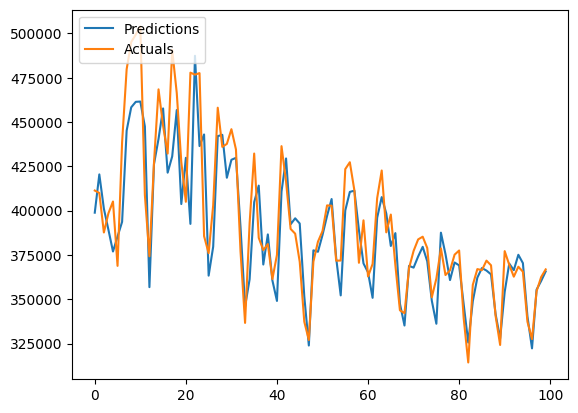

MAPE: 2.88%
RMSE: 15987.32
MAE : 11163.37


Predictions    Actuals
0    398847.93750  411339.27
1    420437.50000  409963.40
2    401102.53125  387672.63
3    389200.50000  398542.65
4    376948.78125  405159.36
..            ...        ...
353  367841.18750  360393.59
354  366874.40625  369325.03
355  380101.37500  371819.56
356  409445.68750  399427.25
357  405955.81250  408178.89

[358 rows x 2 columns]

In [182]:
predictions_plot(model23, X_test23, y_test23, 0, 100)

## Model 20 Re-Run (Post Optuna Trial 2) ##

In [183]:
preprocessor = TimeSeriesPreprocessorTT(seasonsWdWeDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data24 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

X_train24, y_train24 = data24['train']
X_test24, y_test24 = data24['test']

i = X_train24.shape[1]
j = X_train24.shape[2]

In [184]:
# set seed
reset_seed()

model24 = Sequential()
model24.add(InputLayer((i, j)))
model24.add(LSTM(57, dropout=0.013))
model24.add(Dense(8, 'tanh'))
model24.add(Dense(1, 'linear'))

model24.summary()

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_23 (LSTM)                  │ (None, 57)             │        16,188 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 8)              │           464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,661 (65.08 KB)

 Trainable params: 16,661 (65.08 KB)

 Non-trainable params: 0 (0.00 B)

In [185]:
cp24 = ModelCheckpoint('model24.keras', monitor='loss', save_best_only=True)
model24.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0012, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history24 = model24.fit(X_train24, y_train24, epochs=100, batch_size=32, callbacks=[cp24])

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0715 - root_mean_squared_error: 0.2575
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0148 - root_mean_squared_error: 0.1215
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0113 - root_mean_squared_error: 0.1064
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0109 - root_mean_squared_error: 0.1044
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0096 - root_mean_squared_error: 0.0981
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0099 - root_mean_squared_error: 0.0995
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0095 - root_mean_squared_error: 0.0977
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0093 - root_mean_squared_error: 0.0964
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0093 - root_mean_squared_error: 0.0962
Epoch 10/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0089 - root_mean_squared_error: 0.0945

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


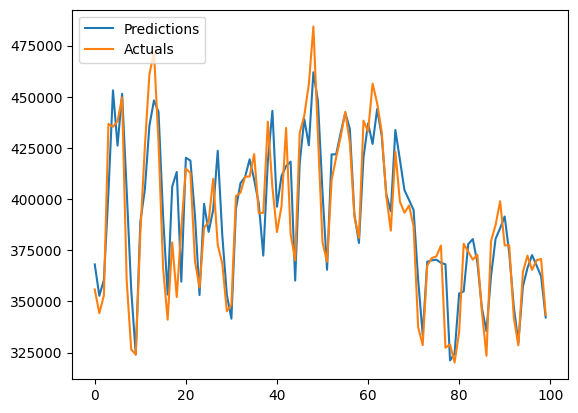

MAPE: 2.54%
RMSE: 13869.55
MAE : 9799.79


Predictions    Actuals
0     368063.40625  355814.96
1     352725.37500  344216.79
2     360415.00000  352812.68
3     403227.65625  436716.40
4     453135.09375  435360.14
...            ...        ...
1084  390627.93750  405457.46
1085  427712.40625  421027.63
1086  409767.75000  407376.71
1087  398726.18750  402263.51
1088  421296.78125  405023.08

[1089 rows x 2 columns]

In [186]:
model24 = load_model('model24.keras')

predictions_plot(model24, X_train24, y_train24, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


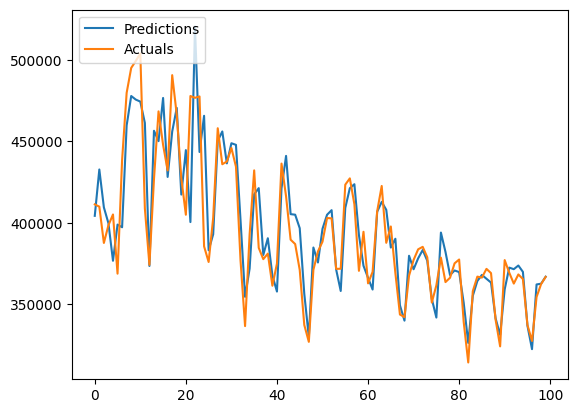

MAPE: 2.95%
RMSE: 16208.83
MAE : 11320.76


Predictions    Actuals
0    404314.00000  411339.27
1    432752.75000  409963.40
2    409508.18750  387672.63
3    399794.15625  398542.65
4    376752.84375  405159.36
..            ...        ...
353  371223.00000  360393.59
354  373104.65625  369325.03
355  396127.00000  371819.56
356  415911.50000  399427.25
357  411806.15625  408178.89

[358 rows x 2 columns]

In [187]:
predictions_plot(model24, X_test24, y_test24, 0, 100)

## Model 20 Re-Run (Post Optuna) - Batch Size Adjust ##

In [188]:
preprocessor = TimeSeriesPreprocessorTT(seasonsWdWeDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data25 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

X_train25, y_train25 = data25['train']
X_test25, y_test25 = data25['test']

i = X_train25.shape[1]
j = X_train25.shape[2]

In [189]:
# set seed
reset_seed()

model25 = Sequential()
model25.add(InputLayer((i, j)))
model25.add(LSTM(32, dropout=0.013))
model25.add(Dense(8, 'tanh'))
model25.add(Dense(1, 'linear'))

model25.summary()

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_24 (LSTM)                  │ (None, 32)             │         5,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,161 (24.07 KB)

 Trainable params: 6,161 (24.07 KB)

 Non-trainable params: 0 (0.00 B)

In [190]:
cp25 = ModelCheckpoint('model25.keras', monitor='loss', save_best_only=True)
model25.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0005, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history25 = model25.fit(X_train25, y_train25, epochs=100, batch_size=4, callbacks=[cp25])

Epoch 1/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0506 - root_mean_squared_error: 0.2112
Epoch 2/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0112 - root_mean_squared_error: 0.1057
Epoch 3/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0099 - root_mean_squared_error: 0.0995
Epoch 4/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0095 - root_mean_squared_error: 0.0975
Epoch 5/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0091 - root_mean_squared_error: 0.0955
Epoch 6/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0086 - root_mean_squared_error: 0.0924
Epoch 7/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0093 - root_mean_squared_error: 0.0961
Epoch 8/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0083 - root_mean_squared_error: 0.0907
Epoch 9/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0090 - root_mean_squared_error: 0.0938
Epoch 10/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0078 - root_mean_s

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


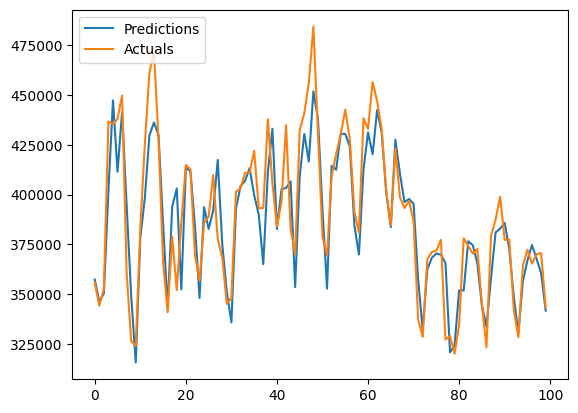

MAPE: 2.57%
RMSE: 14146.28
MAE : 10056.44


Predictions    Actuals
0     357426.59375  355814.96
1     346415.03125  344216.79
2     350410.06250  352812.68
3     402119.00000  436716.40
4     447312.03125  435360.14
...            ...        ...
1084  382792.21875  405457.46
1085  419191.06250  421027.63
1086  398460.62500  407376.71
1087  384041.81250  402263.51
1088  409528.65625  405023.08

[1089 rows x 2 columns]

In [191]:
model25 = load_model('model25.keras')

predictions_plot(model25, X_train25, y_train25, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


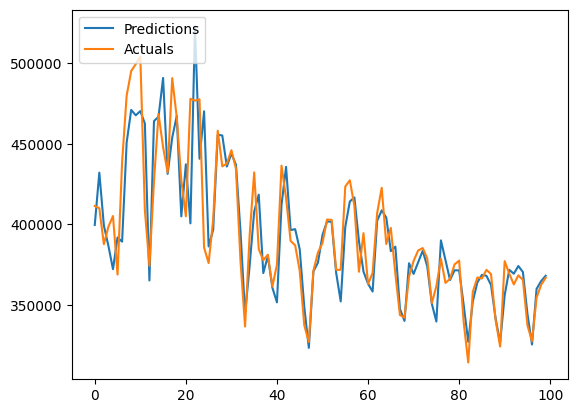

MAPE: 2.84%
RMSE: 16023.58
MAE : 10976.86


Predictions    Actuals
0    399637.62500  411339.27
1    432043.37500  409963.40
2    399242.81250  387672.63
3    386595.87500  398542.65
4    372199.93750  405159.36
..            ...        ...
353  363632.37500  360393.59
354  370656.37500  369325.03
355  386660.00000  371819.56
356  411635.53125  399427.25
357  405933.68750  408178.89

[358 rows x 2 columns]

In [ ]:
predictions_plot(model25, X_test25, y_test25, 0, 100)

## Stacked LSTM - From Model 23 ##

In [192]:
preprocessor = TimeSeriesPreprocessorTT(seasonsWdWeDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data26 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

X_train26, y_train26 = data26['train']
X_test26, y_test26 = data26['test']

i = X_train26.shape[1]
j = X_train26.shape[2]

In [193]:
# set seed
reset_seed()

model26 = Sequential()
model26.add(InputLayer((i, j)))
model26.add(LSTM(32, dropout=0.013, return_sequences=True))
model26.add(LSTM(16, dropout=0.013))
model26.add(Dense(8, 'tanh'))
model26.add(Dense(1, 'linear'))

model26.summary()

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_25 (LSTM)                  │ (None, 7, 32)          │         5,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_26 (LSTM)                  │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,169 (35.82 KB)

 Trainable params: 9,169 (35.82 KB)

 Non-trainable params: 0 (0.00 B)

In [194]:
cp26 = ModelCheckpoint('model26.keras', monitor='loss', save_best_only=True)
model26.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0005, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history26 = model26.fit(X_train26, y_train26, epochs=100, batch_size=8, callbacks=[cp26])

Epoch 1/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0812 - root_mean_squared_error: 0.2677
Epoch 2/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0143 - root_mean_squared_error: 0.1195
Epoch 3/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0142 - root_mean_squared_error: 0.1188
Epoch 4/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0132 - root_mean_squared_error: 0.1149
Epoch 5/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0121 - root_mean_squared_error: 0.1100
Epoch 6/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0120 - root_mean_squared_error: 0.1093
Epoch 7/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0116 - root_mean_squared_error: 0.1075
Epoch 8/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0123 - root_mean_squared_error: 0.1106
Epoch 9/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0114 - root_mean_squared_error: 0.1067
Epoch 10/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0112 - root_mean_s

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


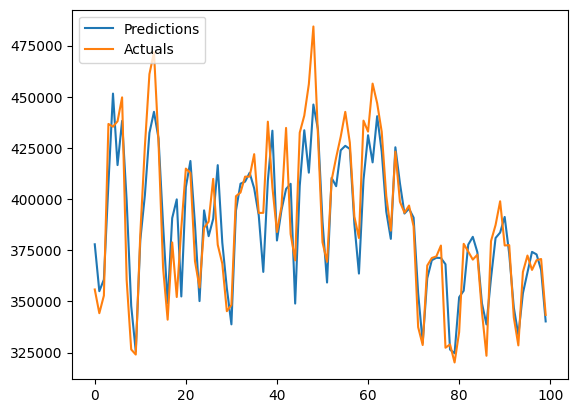

MAPE: 2.54%
RMSE: 13926.88
MAE : 9851.49


Predictions    Actuals
0     377897.71875  355814.96
1     354975.62500  344216.79
2     360654.09375  352812.68
3     407569.75000  436716.40
4     451557.71875  435360.14
...            ...        ...
1084  384703.18750  405457.46
1085  418874.03125  421027.63
1086  412689.37500  407376.71
1087  392465.31250  402263.51
1088  413444.78125  405023.08

[1089 rows x 2 columns]

In [195]:
model26 = load_model('model26.keras')

predictions_plot(model26, X_train26, y_train26, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


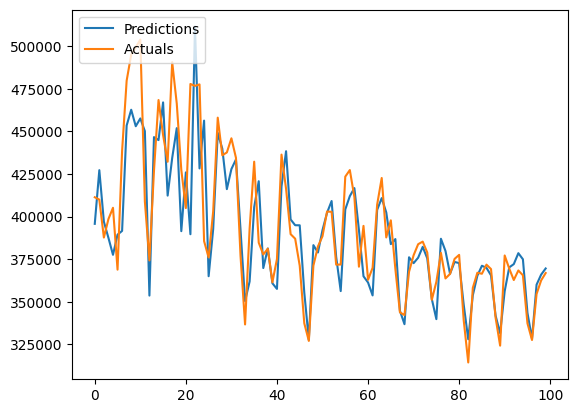

MAPE: 3.08%
RMSE: 16948.44
MAE : 11857.56


Predictions    Actuals
0    395728.43750  411339.27
1    427242.12500  409963.40
2    396982.93750  387672.63
3    387515.84375  398542.65
4    377545.12500  405159.36
..            ...        ...
353  364925.56250  360393.59
354  367402.46875  369325.03
355  393207.56250  371819.56
356  422799.53125  399427.25
357  406821.28125  408178.89

[358 rows x 2 columns]

In [196]:
predictions_plot(model26, X_test26, y_test26, 0, 100)

## CNN-LSTM Test - From Model 23 ##

In [197]:
preprocessor = TimeSeriesPreprocessorTT(seasonsWdWeDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data27 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

X_train27, y_train27 = data27['train']
X_test27, y_test27 = data27['test']

i = X_train27.shape[1]
j = X_train27.shape[2]

In [198]:
# set seed
reset_seed()

model27 = Sequential()
model27.add(InputLayer((i, j)))
model27.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model27.add(MaxPooling1D(pool_size=2))
model27.add(Dropout(0.013))
model27.add(LSTM(32, dropout=0.013))
model27.add(Dense(8, 'tanh'))
model27.add(Dense(1, 'linear'))

model27.summary()

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 5, 64)          │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 2, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_27 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,249 (59.57 KB)

 Trainable params: 15,249 (59.57 KB)

 Non-trainable params: 0 (0.00 B)

In [199]:
cp27 = ModelCheckpoint('model27.keras', monitor='loss', save_best_only=True)
model27.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0005, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history27 = model27.fit(X_train27, y_train27, epochs=100, batch_size=8, callbacks=[cp27])

Epoch 1/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0976 - root_mean_squared_error: 0.2918
Epoch 2/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0126 - root_mean_squared_error: 0.1120
Epoch 3/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0121 - root_mean_squared_error: 0.1097
Epoch 4/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0119 - root_mean_squared_error: 0.1092
Epoch 5/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0119 - root_mean_squared_error: 0.1086
Epoch 6/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0112 - root_mean_squared_error: 0.1057
Epoch 7/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0109 - root_mean_squared_error: 0.1041
Epoch 8/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0107 - root_mean_squared_error: 0.1032
Epoch 9/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0108 - root_mean_squared_error: 0.1037
Epoch 10/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0100 - root_mean_s

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


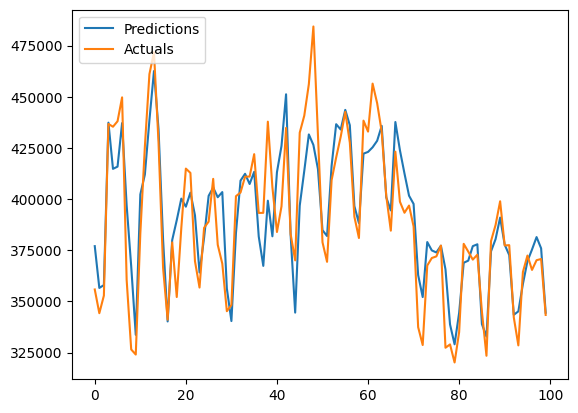

MAPE: 2.85%
RMSE: 14363.78
MAE : 10876.28


Predictions    Actuals
0     376992.18750  355814.96
1     356566.12500  344216.79
2     357962.40625  352812.68
3     437352.96875  436716.40
4     414771.87500  435360.14
...            ...        ...
1084  410597.28125  405457.46
1085  419371.12500  421027.63
1086  400221.68750  407376.71
1087  389321.28125  402263.51
1088  382237.87500  405023.08

[1089 rows x 2 columns]

In [200]:
model27 = load_model('model27.keras')

predictions_plot(model27, X_train27, y_train27, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


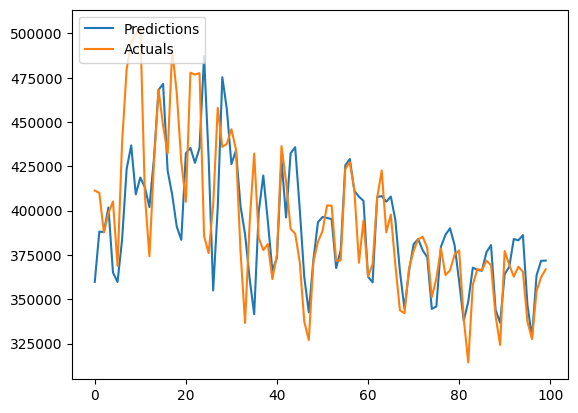

MAPE: 4.87%
RMSE: 25432.66
MAE : 18606.34


Predictions    Actuals
0    359839.00000  411339.27
1    388159.06250  409963.40
2    387947.00000  387672.63
3    401806.81250  398542.65
4    365038.81250  405159.36
..            ...        ...
353  372317.00000  360393.59
354  360522.75000  369325.03
355  390394.71875  371819.56
356  410733.68750  399427.25
357  404019.68750  408178.89

[358 rows x 2 columns]

In [201]:
predictions_plot(model27, X_test27, y_test27, 0, 100)

## CNN-LSTM Optuna Trials ##

In [ ]:
'''study3 = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(seed=42)  # Optional: set seed for reproducibility
)

study3.optimize(objective3, n_trials=100)'''

"study3 = optuna.create_study(\n    direction='minimize',\n    sampler=optuna.samplers.TPESampler(seed=42)  # Optional: set seed for reproducibility\n)\n\nstudy3.optimize(objective3, n_trials=100)"

In [ ]:
'''print("Best trial:")
trial3 = study3.best_trial

print(f"  MAE: {trial3.value:.2f}")
print("  Params:")
for key, value in trial3.params.items():
    print(f"    {key}: {value}")'''

'print("Best trial:")\ntrial3 = study3.best_trial\n\nprint(f"  MAE: {trial3.value:.2f}")\nprint("  Params:")\nfor key, value in trial3.params.items():\n    print(f"    {key}: {value}")'

## Explore Temp^2 ##

In [26]:
seasonsWdWeDemandDF2 = seasonsWdWeDemandDF.copy()
seasonsWdWeDemandDF2['temp2'] = seasonsWdWeDemandDF2['avg_temp']**2
seasonsWdWeDemandDF2.head()


is_weekend  is_weekday  is_winter  is_spring  is_summer  \
datetime_au                                                            
2016-01-01            0           1          0          0          1   
2016-01-02            1           0          0          0          1   
2016-01-03            1           0          0          0          1   
2016-01-04            0           1          0          0          1   
2016-01-05            0           1          0          0          1   

             is_autumn  sum_30_min_demand   avg_temp  min_temp  max_temp  \
datetime_au                                                                
2016-01-01           0          329352.88  20.704082      15.2      26.0   
2016-01-02           0          323133.95  20.572917      14.9      24.2   
2016-01-03           0          317665.92  21.130769      19.0      22.9   
2016-01-04           0          353210.40  20.144444      18.4      23.1   
2016-01-05           0          358082.97  18.904808      17.4      20.3   

             hd_next_24h  cd_next_24h  temp_range       temp2  
datetime_au                                                    
2016-01-01           0.0     1.204082        10.8  428.658996  
2016-01-02           0.0     1.072917         9.3  423.244900  
2016-01-03           0.0     1.630769         3.9  446.509408  
2016-01-04           0.0     0.644444         4.7  405.798642  
2016-01-05           0.0     0.000000         2.9  357.391754

In [203]:
preprocessor = TimeSeriesPreprocessorTT(seasonsWdWeDemandDF2, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data28 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

X_train28, y_train28 = data28['train']
X_test28, y_test28 = data28['test']

i = X_train28.shape[1]
j = X_train28.shape[2]

In [204]:
# set seed
reset_seed()

model28 = Sequential()
model28.add(InputLayer((i, j)))
model28.add(LSTM(32, dropout=0.013))
model28.add(Dense(8, 'tanh'))
model28.add(Dense(1, 'linear'))

model28.summary()

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_28 (LSTM)                  │ (None, 32)             │         6,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,289 (24.57 KB)

 Trainable params: 6,289 (24.57 KB)

 Non-trainable params: 0 (0.00 B)

In [205]:
cp28 = ModelCheckpoint('model28.keras', monitor='loss', save_best_only=True)
model28.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0005, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history28 = model28.fit(X_train28, y_train28, epochs=100, batch_size=8, callbacks=[cp28])

Epoch 1/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0596 - root_mean_squared_error: 0.2337
Epoch 2/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0147 - root_mean_squared_error: 0.1210
Epoch 3/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0114 - root_mean_squared_error: 0.1066
Epoch 4/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0107 - root_mean_squared_error: 0.1034
Epoch 5/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0097 - root_mean_squared_error: 0.0985
Epoch 6/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0094 - root_mean_squared_error: 0.0967
Epoch 7/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0091 - root_mean_squared_error: 0.0951
Epoch 8/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0096 - root_mean_squared_error: 0.0976
Epoch 9/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0088 - root_mean_squared_error: 0.0936
Epoch 10/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0087 - root_mean_s

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


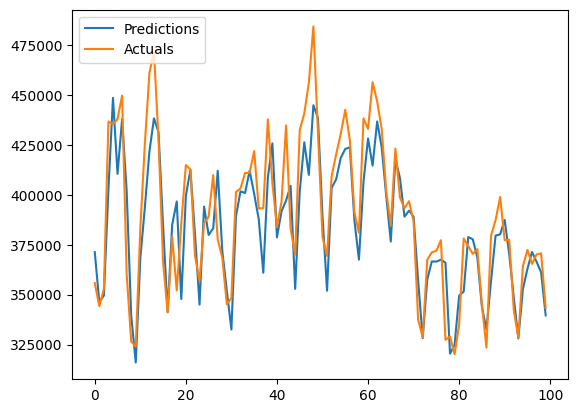

MAPE: 2.78%
RMSE: 15331.01
MAE : 10910.62


Predictions    Actuals
0     371274.06250  355814.96
1     346235.96875  344216.79
2     349520.28125  352812.68
3     402712.25000  436716.40
4     448593.09375  435360.14
...            ...        ...
1084  386895.40625  405457.46
1085  429048.56250  421027.63
1086  404663.90625  407376.71
1087  375941.75000  402263.51
1088  410425.62500  405023.08

[1089 rows x 2 columns]

In [206]:
model28 = load_model('model28.keras')

predictions_plot(model28, X_train28, y_train28, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


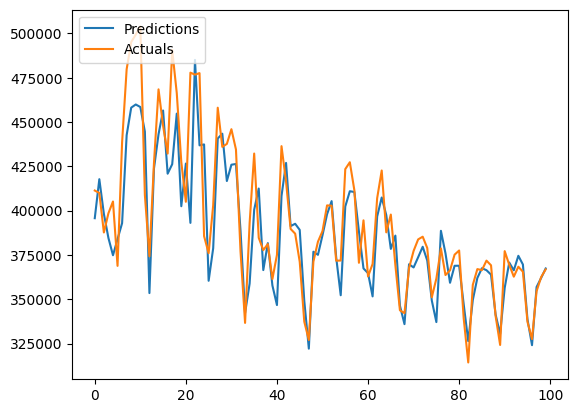

MAPE: 2.91%
RMSE: 16172.47
MAE : 11320.05


Predictions    Actuals
0    395730.68750  411339.27
1    417738.78125  409963.40
2    398201.40625  387672.63
3    384559.93750  398542.65
4    374839.68750  405159.36
..            ...        ...
353  363478.62500  360393.59
354  362181.87500  369325.03
355  380363.75000  371819.56
356  413664.03125  399427.25
357  408064.40625  408178.89

[358 rows x 2 columns]

In [207]:
predictions_plot(model28, X_test28, y_test28, 0, 100)

## Explore Recurrent Dropout ##

In [208]:
preprocessor = TimeSeriesPreprocessorTT(seasonsWdWeDemandDF2, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data29 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

X_train29, y_train29 = data29['train']
X_test29, y_test29 = data29['test']

i = X_train29.shape[1]
j = X_train29.shape[2]

In [209]:
# set seed
reset_seed()

model29 = Sequential()
model29.add(InputLayer((i, j)))
model29.add(LSTM(32, dropout=0.013, recurrent_dropout=0.013))
model29.add(Dense(8, 'tanh'))
model29.add(Dense(1, 'linear'))

model29.summary()

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_29 (LSTM)                  │ (None, 32)             │         6,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,289 (24.57 KB)

 Trainable params: 6,289 (24.57 KB)

 Non-trainable params: 0 (0.00 B)

In [210]:
cp29 = ModelCheckpoint('model29.keras', monitor='loss', save_best_only=True)
model29.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0005, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history29 = model29.fit(X_train29, y_train29, epochs=100, batch_size=8, callbacks=[cp29])

Epoch 1/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0611 - root_mean_squared_error: 0.2370
Epoch 2/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0145 - root_mean_squared_error: 0.1202
Epoch 3/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0117 - root_mean_squared_error: 0.1080
Epoch 4/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0105 - root_mean_squared_error: 0.1024
Epoch 5/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0099 - root_mean_squared_error: 0.0994
Epoch 6/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0092 - root_mean_squared_error: 0.0955
Epoch 7/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0093 - root_mean_squared_error: 0.0965
Epoch 8/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0091 - root_mean_squared_error: 0.0954
Epoch 9/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0091 - root_mean_squared_error: 0.0952
Epoch 10/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0090 - r

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


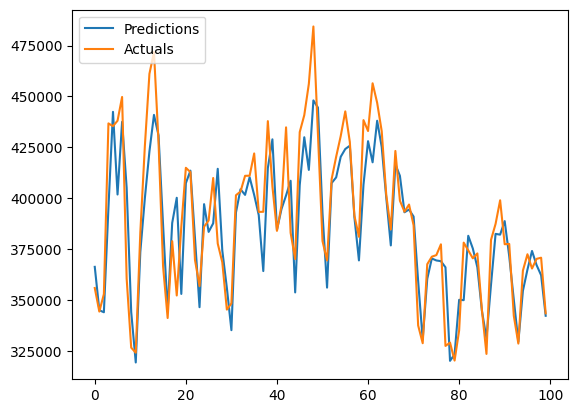

MAPE: 2.71%
RMSE: 15026.96
MAE : 10573.07


Predictions    Actuals
0     366204.53125  355814.96
1     344872.12500  344216.79
2     343893.68750  352812.68
3     395116.81250  436716.40
4     442393.37500  435360.14
...            ...        ...
1084  380416.43750  405457.46
1085  418085.00000  421027.63
1086  398193.53125  407376.71
1087  373558.84375  402263.51
1088  413895.65625  405023.08

[1089 rows x 2 columns]

In [211]:
model29 = load_model('model29.keras')

predictions_plot(model29, X_train29, y_train29, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


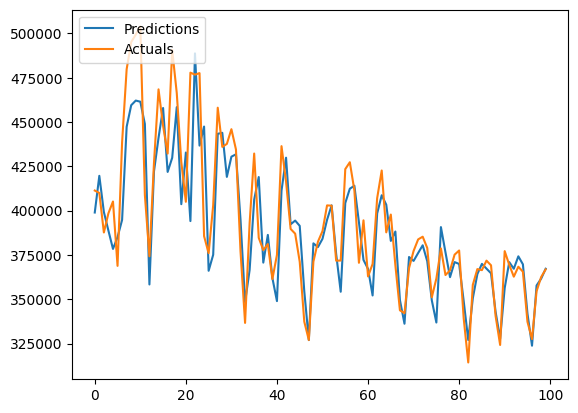

MAPE: 2.87%
RMSE: 15949.87
MAE : 11108.65


Predictions    Actuals
0    398934.71875  411339.27
1    419639.87500  409963.40
2    399213.50000  387672.63
3    388701.06250  398542.65
4    378406.78125  405159.36
..            ...        ...
353  363733.68750  360393.59
354  360232.78125  369325.03
355  369701.96875  371819.56
356  403205.46875  399427.25
357  394863.96875  408178.89

[358 rows x 2 columns]

In [212]:
predictions_plot(model29, X_test29, y_test29, 0, 100)

## Recurrent Optuna Trial w/ temp^2 ##

In [ ]:
'''study4 = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(seed=42)  # Optional: set seed for reproducibility
)

study4.optimize(objective4, n_trials=100)'''

"study4 = optuna.create_study(\n    direction='minimize',\n    sampler=optuna.samplers.TPESampler(seed=42)  # Optional: set seed for reproducibility\n)\n\nstudy4.optimize(objective4, n_trials=100)"

In [ ]:
'''print("Best trial:")
trial3 = study4.best_trial

print(f"  MAE: {trial4.value:.2f}")
print("  Params:")
for key, value in trial4.params.items():
    print(f"    {key}: {value}")'''

## Temp^2/Recurrent Dropout (Post Optuna) ##

In [48]:
preprocessor = TimeSeriesPreprocessorTT(seasonsWdWeDemandDF2, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data30 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

X_train30, y_train30 = data30['train']
X_test30, y_test30 = data30['test']

i = X_train30.shape[1]
j = X_train30.shape[2]

In [49]:
# If df is your DataFrame
feature_names = seasonsWdWeDemandDF2.columns.tolist()
feature_names

['is_weekend',
 'is_weekday',
 'is_winter',
 'is_spring',
 'is_summer',
 'is_autumn',
 'sum_30_min_demand',
 'avg_temp',
 'min_temp',
 'max_temp',
 'hd_next_24h',
 'cd_next_24h',
 'temp_range',
 'temp2']

In [50]:
seasonsWdWeDemandDF2.head()

is_weekend  is_weekday  is_winter  is_spring  is_summer  \
datetime_au                                                            
2016-01-01            0           1          0          0          1   
2016-01-02            1           0          0          0          1   
2016-01-03            1           0          0          0          1   
2016-01-04            0           1          0          0          1   
2016-01-05            0           1          0          0          1   

             is_autumn  sum_30_min_demand   avg_temp  min_temp  max_temp  \
datetime_au                                                                
2016-01-01           0          329352.88  20.704082      15.2      26.0   
2016-01-02           0          323133.95  20.572917      14.9      24.2   
2016-01-03           0          317665.92  21.130769      19.0      22.9   
2016-01-04           0          353210.40  20.144444      18.4      23.1   
2016-01-05           0          358082.97  18.904808      17.4      20.3   

             hd_next_24h  cd_next_24h  temp_range       temp2  
datetime_au                                                    
2016-01-01           0.0     1.204082        10.8  428.658996  
2016-01-02           0.0     1.072917         9.3  423.244900  
2016-01-03           0.0     1.630769         3.9  446.509408  
2016-01-04           0.0     0.644444         4.7  405.798642  
2016-01-05           0.0     0.000000         2.9  357.391754

In [51]:
# set seed
reset_seed()

model30 = Sequential()
model30.add(InputLayer((i, j)))
model30.add(LSTM(64, dropout=0.00145, recurrent_dropout=0.3))
model30.add(Dense(8, 'tanh'))
model30.add(Dense(1, 'linear'))

model30.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        20,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,753 (81.07 KB)

 Trainable params: 20,753 (81.07 KB)

 Non-trainable params: 0 (0.00 B)

In [52]:
cp30 = ModelCheckpoint('model30.keras', monitor='loss', save_best_only=True)
model30.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.00311, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history30 = model30.fit(X_train30, y_train30, epochs=100, batch_size=32, callbacks=[cp30])

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0967 - root_mean_squared_error: 0.2988
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0121 - root_mean_squared_error: 0.1102
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0105 - root_mean_squared_error: 0.1022
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0100 - root_mean_squared_error: 0.0999
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0099 - root_mean_squared_error: 0.0994
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0093 - root_mean_squared_error: 0.0965
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0092 - root_mean_squared_error: 0.0960
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0084 - root_mean_squared_error: 0.0919
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0083 - root_mean_squared_error: 0.0910
Epoch 10/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0080 - root_mean_squared_err

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


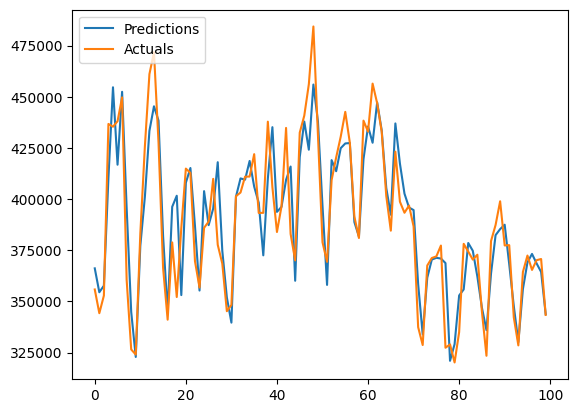

MAPE: 2.43%
RMSE: 13159.56
MAE : 9380.01


Predictions    Actuals
0     366137.15625  355814.96
1     354454.90625  344216.79
2     357672.37500  352812.68
3     410376.28125  436716.40
4     454642.59375  435360.14
...            ...        ...
1084  383894.96875  405457.46
1085  419585.78125  421027.63
1086  395818.31250  407376.71
1087  381854.87500  402263.51
1088  403308.15625  405023.08

[1089 rows x 2 columns]

In [53]:
model30 = load_model('model30.keras')

predictions_plot(model30, X_train30, y_train30, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Plot saved to final_predictions.png


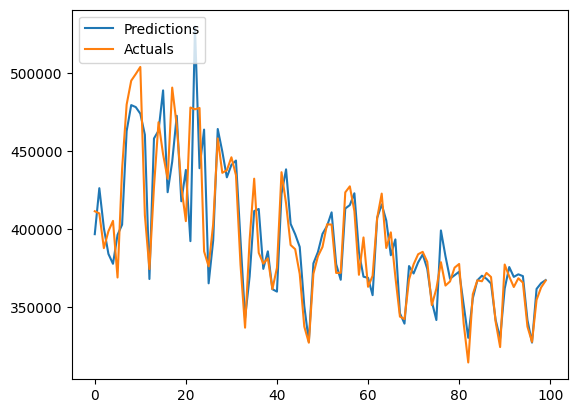

MAPE: 2.76%
RMSE: 15622.76
MAE : 10608.65


Predictions    Actuals
0    396631.65625  411339.27
1    426123.93750  409963.40
2    400492.34375  387672.63
3    383961.37500  398542.65
4    377638.12500  405159.36
..            ...        ...
353  359031.62500  360393.59
354  358034.84375  369325.03
355  379975.75000  371819.56
356  413305.15625  399427.25
357  399074.75000  408178.89

[358 rows x 2 columns]

In [55]:
predictions_plot(model30, X_test30, y_test30, 0, 100, save_path='final_predictions.png')

## Test Attention ##

In [218]:
@register_keras_serializable(package="Custom")
class SimpleAttention(Layer):
    def __init__(self, return_attention=False, **kwargs):
        super(SimpleAttention, self).__init__(**kwargs)
        self.return_attention = return_attention

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight",
                                 shape=(input_shape[-1], 1),
                                 initializer="normal",
                                 trainable=True)
        self.b = self.add_weight(name="att_bias",
                                 shape=(input_shape[1], 1),
                                 initializer="zeros",
                                 trainable=True)
        super(SimpleAttention, self).build(input_shape)

    def call(self, x):
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        a = tf.keras.backend.softmax(e, axis=1)  # attention weights
        context = tf.reduce_sum(x * a, axis=1)
        if self.return_attention:
            return [context, a]   # return both if requested
        return context

    def get_config(self):
        config = super(SimpleAttention, self).get_config()
        config.update({"return_attention": self.return_attention})
        return config

In [219]:
preprocessor = TimeSeriesPreprocessorTT(seasonsWdWeDemandDF2, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data31 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

X_train31, y_train31 = data31['train']
X_test31, y_test31 = data31['test']

i = X_train31.shape[1]
j = X_train31.shape[2]

In [220]:
# set seed
reset_seed()

inputs = Input(shape=(i, j))  # i = window_size, j = features
lstm_out = LSTM(64, return_sequences=True,
                dropout=0.00145, recurrent_dropout=0.3, name='LSTM')(inputs)

context, att_weights = SimpleAttention(return_attention=True)(lstm_out)
dense = Dense(8, activation='tanh')(context)
outputs = Dense(1, activation='linear')(dense)

model31 = Model(inputs, outputs)

In [221]:
cp31 = ModelCheckpoint('model31.keras', monitor='loss', save_best_only=True)
model31.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.00311, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history31 = model31.fit(X_train31, y_train31, epochs=100, batch_size=32, callbacks=[cp31])

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0398 - root_mean_squared_error: 0.1952
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0150 - root_mean_squared_error: 0.1224
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0140 - root_mean_squared_error: 0.1184
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0127 - root_mean_squared_error: 0.1128
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0127 - root_mean_squared_error: 0.1125
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0121 - root_mean_squared_error: 0.1102
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0121 - root_mean_squared_error: 0.1099
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0119 - root_mean_squared_error: 0.1091
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0118 - root_mean_squared_error: 0.1088
Epoch 10/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0117 - root_mean_squared_err

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


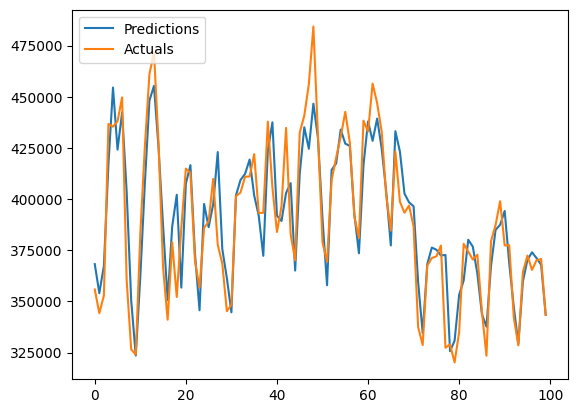

MAPE: 2.46%
RMSE: 13102.78
MAE : 9412.61


Predictions    Actuals
0     368210.43750  355814.96
1     354016.90625  344216.79
2     367321.43750  352812.68
3     416938.43750  436716.40
4     454498.56250  435360.14
...            ...        ...
1084  401171.31250  405457.46
1085  426966.56250  421027.63
1086  414629.50000  407376.71
1087  398420.09375  402263.51
1088  417477.46875  405023.08

[1089 rows x 2 columns]

In [222]:
model31 = load_model('model31.keras')

predictions_plot(model31, X_train31, y_train31, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


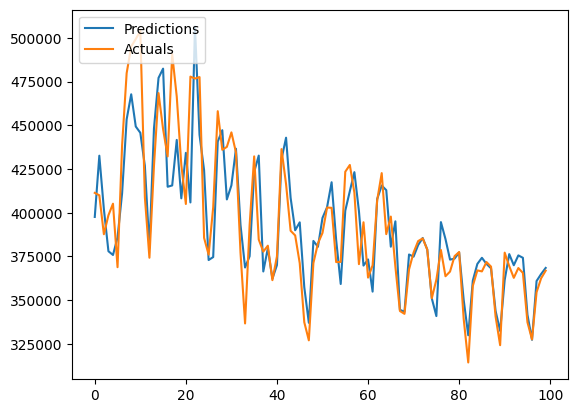

MAPE: 3.24%
RMSE: 17409.29
MAE : 12424.50


Predictions    Actuals
0    397576.28125  411339.27
1    432606.40625  409963.40
2    402021.09375  387672.63
3    377967.43750  398542.65
4    375825.28125  405159.36
..            ...        ...
353  379108.40625  360393.59
354  370291.25000  369325.03
355  401492.93750  371819.56
356  431281.53125  399427.25
357  408380.90625  408178.89

[358 rows x 2 columns]

In [223]:
predictions_plot(model31, X_test31, y_test31, 0, 100)

In [33]:
import shap

  0%|          | 0/100 [00:00<?, ?it/s]

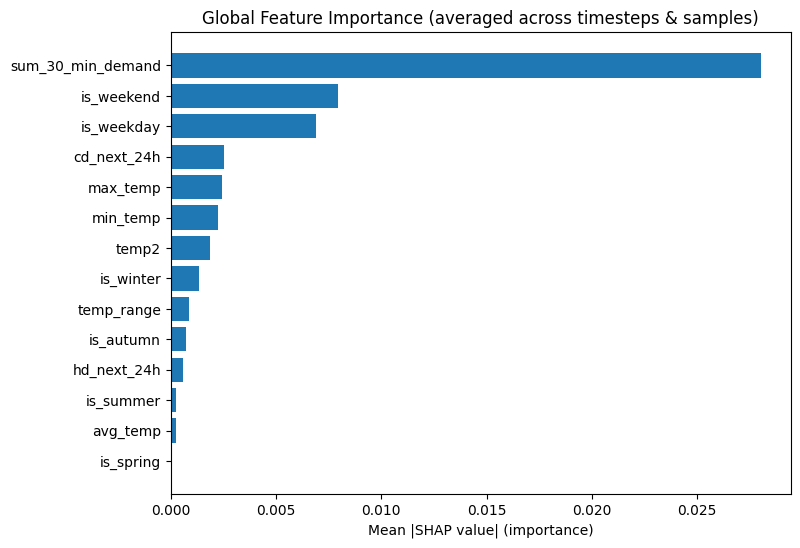

In [37]:
# --- 1. Flatten your data for SHAP ---
X_train_flat = X_train30.reshape(X_train30.shape[0], -1)  # (n_samples, 98)
X_test_flat  = X_test30.reshape(X_test30.shape[0], -1)

# --- 2. Define prediction function ---
def predict_fn(x):
    x_reshaped = x.reshape(x.shape[0], 7, 14)
    return model30.predict(x_reshaped, verbose=0)

# --- 3. Background and test subsets ---
background = X_train_flat[:200]
X_explain  = X_test_flat[:100]

# --- 4. KernelExplainer ---
explainer = shap.KernelExplainer(predict_fn, background)
shap_values = explainer.shap_values(X_explain)

# shap_values shape: (samples, 98)

# --- 5. Reshape back to (samples, timesteps, features) ---
shap_values = np.array(shap_values).reshape(len(X_explain), 7, 14)

# --- 6. Average across timesteps and samples ---
# Result: one importance score per feature
feature_importance = np.mean(np.abs(shap_values), axis=(0,1))

# --- 7. Plot bar chart ---
sorted_idx = np.argsort(feature_importance)[::-1]

plt.figure(figsize=(8,6))
plt.barh([feature_names[i] for i in sorted_idx], feature_importance[sorted_idx])
plt.gca().invert_yaxis()
plt.xlabel("Mean |SHAP value| (importance)")
plt.title("Global Feature Importance (averaged across timesteps & samples)")
plt.show()

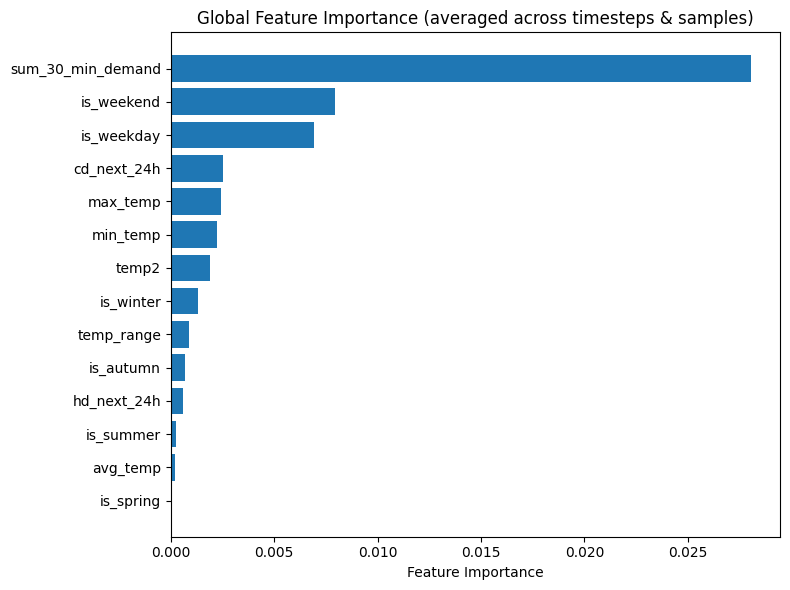

In [42]:
plt.figure(figsize=(8,6))
plt.barh([feature_names[i] for i in sorted_idx], feature_importance[sorted_idx])
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.title("Global Feature Importance (averaged across timesteps & samples)")
plt.tight_layout()
plt.savefig("LSTM_feat_imp.png")
plt.show()


In [56]:
pip install nbstripout


In [58]:
!nbstripout LSTM-sum_demand.ipynb